In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

Setting environment for Precision WorkStation


No vtk
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
stack = 'MD662'

# Download raw scanner files from S3

In [ ]:
! aws s3 cp --recursive --force-glacier-transfer "s3://mousebrainatlas-rawdata/CSHL_data/MD662" "/shared/CSHL_data/MD662"

# Specify raw file locations

In [11]:
# FOR MD658

# The set of dirs where we should search for image files.
raw_data_dirs = \
{(None, 'raw'): '/media/yuncong/BstemAtlasData/MD658/',
(None, 'down32'): '/media/yuncong/BstemAtlasData/MD658/'}

# Specifies how to extract image name from file path.
# The first group returned by re.search is image_name.
input_image_filename_to_imagename_re_pattern_mapping = \
{(None, 'raw'): \
 '/media/yuncong/BstemAtlasData/MD658/(.*)_lossless.jp2',
 (None, 'down32'): \
  '/media/yuncong/BstemAtlasData/MD658/(.*).png',
}

In [65]:
# FOR MD661

# The set of dirs where we should search for image files.
raw_data_dirs = \
{(None, 'raw'): '/media/yuncong/BstemAtlasData/MD661/',
(None, 'down32'): '/media/yuncong/BstemAtlasData/MD661/'}

# Specifies how to extract image name from file path.
# The first group returned by re.search is image_name.
input_image_filename_to_imagename_re_pattern_mapping = \
{(None, 'raw'): \
 '/media/yuncong/BstemAtlasData/MD661/(.*)_lossless.jp2',
 (None, 'down32'): \
  '/media/yuncong/BstemAtlasData/MD661/(.*).tif',
}

In [4]:
# FOR MD662

# The set of dirs where we should search for image files.
raw_data_dirs = \
{(None, 'raw'): '/media/yuncong/BstemAtlasData/MD662/',
(None, 'down32'): '/media/yuncong/BstemAtlasData/MD662/'}

# Specifies how to extract image name from file path.
# The first group returned by re.search is image_name.
input_image_filename_to_imagename_re_pattern_mapping = \
{(None, 'raw'): \
 '/media/yuncong/BstemAtlasData/MD662/(.*)_lossless.jp2',
 (None, 'down32'): \
  '/media/yuncong/BstemAtlasData/MD662/(.*).tif',
}

In [5]:
image_names_all_data_dirs_flattened = set([])
image_names_all_data_dirs = {}
for vr, data_dir in raw_data_dirs.iteritems():
    if data_dir is None: continue
    image_names = set([])
    if vr in input_image_filename_to_imagename_re_pattern_mapping:
        for fn in os.listdir(data_dir):
            g = re.search(input_image_filename_to_imagename_re_pattern_mapping[vr], os.path.join(data_dir, fn))
            if g is not None:
                img_name = g.groups()[0]
                image_names.add(img_name)
                image_names_all_data_dirs_flattened.add(img_name)
    image_names_all_data_dirs[vr] = image_names
    
# Make sure the every image has all three channels.
for vr, img_names in image_names_all_data_dirs.iteritems():
    print vr, 'missing:'
    print image_names_all_data_dirs_flattened - img_names
    print 

(None, 'raw') missing:
set([])

(None, 'down32') missing:
set([])



# Convert JPEG2000 to TIFF
jp2 -> raw

In [6]:
# in_dir = '/shared/CSHL_data/MD662/'
in_dir = '/media/yuncong/BstemAtlasData/MD662/'

In [7]:
# thumbnail_files = [fn for fn in os.listdir(in_dir) if 'tif' in fn]
thumbnail_files = [fn for fn in os.listdir(in_dir) if 'png' in fn]
raw_files =  [fn for fn in os.listdir(in_dir) if 'lossless' in fn]
print len(raw_files), 'raw files, ', len(thumbnail_files), 'thumbnail_files'

438 raw files,  438 thumbnail_files


In [19]:
output_dir = create_if_not_exists(DataManager.get_image_dir_v2(stack=stack, prep_id=None, resol='raw'))

In [ ]:
run_distributed('export LD_LIBRARY_PATH=%(kdu_dir)s:$LD_LIBRARY_PATH; %(kdu_bin)s -i \"%%(in_fp)s\" -o \"%%(out_fp)s\"' % \
                {'kdu_bin': KDU_EXPAND_BIN, 'kdu_dir': os.path.dirname(KDU_EXPAND_BIN)},
                kwargs_list={'in_fp': [os.path.join(in_dir, img_name + '_lossless.jp2') 
                                       for img_name in list(image_names_all_data_dirs_flattened)], 
                             'out_fp': [DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                        resol='raw', version=None, fn=img_name) 
                                        for img_name in list(image_names_all_data_dirs_flattened)]},
                argument_type='single',
                jobs_per_node=1,
                local_only=True, 
                use_aws=False)

In [ ]:
# upload_to_s3(DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='raw', version=None), is_dir=True)

# Extract Neurotrace channel
raw -> raw_Ntb

In [39]:
create_if_not_exists(DataManager.get_image_dir_v2(stack=stack, prep_id=None, resol='raw', version='Ntb'))

'/data/CSHL_data_processed/MD662/MD662_raw_Ntb'

In [71]:
ff = set(metadata_cache['valid_filenames'][stack]) - set([fp[:-12] for fp in os.listdir('/data/CSHL_data_processed/MD662/MD662_raw_Ntb/')])

In [72]:
run_distributed5('convert \"%(in_fp)s\" -channel B -separate \"%(out_fp)s\"',
                kwargs_list=[{'in_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                        resol='raw', version=None, fn=img_name),
                                       'out_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                        resol='raw', version='Ntb', fn=img_name)}
                                       for img_name in ff],
                argument_type='single',
                jobs_per_node=1,
                local_only=True,
               use_aws=False)

rm -f ~/stderr_*; rm -f ~/stdout_*
return code: 0
Run locally.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


In [ ]:
run_distributed('convert \"%(in_fp)s\" -channel B -separate \"%(out_fp)s\"',
                kwargs_list={'in_fp': [DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                        resol='raw', version=None, fn=img_name) 
                                       for img_name in list(image_names_all_data_dirs_flattened)], 
                             'out_fp': [DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                        resol='raw', version='Ntb', fn=img_name) 
                                        for img_name in list(image_names_all_data_dirs_flattened)]},
                argument_type='single',
                jobs_per_node=1,
                local_only=True,
               use_aws=False)

rm -f ~/stderr_*; rm -f ~/stdout_*
return code: 0
Run locally.
Jobs submitted. Use wait_qsub_complete() to wait for all execution to finish.


# Generate thumbnails and linearly contrast stretch
raw_Ntb -> thumbnail_Ntb -> thumbnail_NtbNormalized

In [48]:
thumbnail_downscale_factor = 32
tb_resol = 'thumbnail'

In [ ]:
for img_name in metadata_cache['valid_filenames'][stack]:
# for img_name in ['MD662&661-F41-2017.06.05-20.06.59_MD662_1_0121']:

    t = time.time()

    in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='raw', version='Ntb', fn=img_name)
    out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=tb_resol, version='Ntb', fn=img_name)
    create_parent_dir_if_not_exists(out_fp)
    
    img = imread(in_fp)
    
    img_tb = img[::thumbnail_downscale_factor, ::thumbnail_downscale_factor]
    imsave(out_fp, img_tb)

    # Alternative: ImageMagick introduces an artificial noisy stripe in the output image.
#     cmd = 'convert %(in_fp)s -scale 3.125%% %(out_fp)s' % {'in_fp': in_fp, 'out_fp': out_fp}
#     execute_command(cmd)
        
    sys.stderr.write("Rescale: %.2f seconds.\n" % (time.time() - t)) # ~20s / image
    
    t = time.time()

    in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=tb_resol, version='Ntb', fn=img_name)
    out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=tb_resol, version='NtbNormalized', fn=img_name)
    create_parent_dir_if_not_exists(out_fp)
        
    cmd = """convert "%(in_fp)s" -normalize -depth 8 "%(out_fp)s" """ % {'in_fp': in_fp, 'out_fp': out_fp}
    execute_command(cmd)
    
    sys.stderr.write("Intensity normalize: %.2f seconds.\n" % (time.time() - t))

Rescale: 9.26 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F43-2017.06.05-21.05.21_MD662_3_0129_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD662/MD662_thumbnail_NtbNormalized/MD662&661-F43-2017.06.05-21.05.21_MD662_3_0129_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.11 seconds.
Rescale: 8.64 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F44-2017.06.05-21.36.28_MD662_1_0130_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD662/MD662_thumbnail_NtbNormalized/MD662&661-F44-2017.06.05-21.36.28_MD662_1_0130_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.11 seconds.
Rescale: 10.78 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F44-2017.06.05-21.36.28_MD662_2_0131_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD662/MD662_thumbnail_NtbNormalized/MD662&661-F44-2017.06.05-21.36.28_MD662_2_0131

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F49-2017.06.06-00.05.38_MD662_1_0145_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 10.74 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F49-2017.06.06-00.05.38_MD662_1_0145_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD662/MD662_thumbnail_NtbNormalized/MD662&661-F49-2017.06.06-00.05.38_MD662_1_0145_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.15 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F49-2017.06.06-00.05.38_MD662_2_0146_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 8.51 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F49-2017.06.06-00.05.38

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F53-2017.06.08-17.11.31_MD662_3_0159_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 8.10 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F53-2017.06.08-17.11.31_MD662_3_0159_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD662/MD662_thumbnail_NtbNormalized/MD662&661-F53-2017.06.08-17.11.31_MD662_3_0159_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.16 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F54-2017.06.22-17.00.44_MD662_1_0160_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 8.41 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F54-2017.06.22-17.00.44_

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F58-2017.06.06-02.35.45_MD662_2_0173_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 8.87 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F58-2017.06.06-02.35.45_MD662_2_0173_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD662/MD662_thumbnail_NtbNormalized/MD662&661-F58-2017.06.06-02.35.45_MD662_2_0173_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.16 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F58-2017.06.06-02.35.45_MD662_3_0174_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 8.26 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F58-2017.06.06-02.35.45_

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F63-2017.06.06-05.05.24_MD662_1_0187_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 7.28 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F63-2017.06.06-05.05.24_MD662_1_0187_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD662/MD662_thumbnail_NtbNormalized/MD662&661-F63-2017.06.06-05.05.24_MD662_1_0187_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.14 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F63-2017.06.06-05.05.24_MD662_2_0188_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 7.70 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F63-2017.06.06-05.05.24_

/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F67-2017.06.06-07.07.27_MD662_3_0201_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 13.16 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F67-2017.06.06-07.07.27_MD662_3_0201_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD662/MD662_thumbnail_NtbNormalized/MD662&661-F67-2017.06.06-07.07.27_MD662_3_0201_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.18 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F68-2017.06.06-07.39.27_MD662_1_0202_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 7.32 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F68-2017.06.06-07.39.27

return code: 0
Intensity normalize: 0.20 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F75-2017.06.06-10.19.15_MD662_1_0223_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 21.29 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F75-2017.06.06-10.19.15_MD662_1_0223_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD662/MD662_thumbnail_NtbNormalized/MD662&661-F75-2017.06.06-10.19.15_MD662_1_0223_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.21 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F75-2017.06.06-10.19.15_MD662_2_0224_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 19.19 seconds.
convert "/data/CSHL_data_processed/MD662/MD

return code: 0
Intensity normalize: 0.20 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F82-2017.06.06-13.10.59_MD662_1_0244_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 10.82 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F82-2017.06.06-13.10.59_MD662_1_0244_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD662/MD662_thumbnail_NtbNormalized/MD662&661-F82-2017.06.06-13.10.59_MD662_1_0244_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.19 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F82-2017.06.06-13.10.59_MD662_2_0245_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 20.67 seconds.
convert "/data/CSHL_data_processed/MD662/MD

return code: 0
Intensity normalize: 0.22 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F89-2017.06.06-16.49.49_MD662_1_0265_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 12.42 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F89-2017.06.06-16.49.49_MD662_1_0265_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD662/MD662_thumbnail_NtbNormalized/MD662&661-F89-2017.06.06-16.49.49_MD662_1_0265_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.21 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F89-2017.06.06-16.49.49_MD662_2_0266_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 13.56 seconds.
convert "/data/CSHL_data_processed/MD662/MD

return code: 0
Intensity normalize: 0.20 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F96-2017.06.06-19.55.10_MD662_1_0286_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 10.66 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F96-2017.06.06-19.55.10_MD662_1_0286_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD662/MD662_thumbnail_NtbNormalized/MD662&661-F96-2017.06.06-19.55.10_MD662_1_0286_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.22 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F96-2017.06.06-19.55.10_MD662_2_0287_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 10.45 seconds.
convert "/data/CSHL_data_processed/MD662/MD

return code: 0
Intensity normalize: 0.21 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F103-2017.06.06-22.56.22_MD662_1_0307_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 12.11 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F103-2017.06.06-22.56.22_MD662_1_0307_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD662/MD662_thumbnail_NtbNormalized/MD662&661-F103-2017.06.06-22.56.22_MD662_1_0307_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.21 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F103-2017.06.06-22.56.22_MD662_2_0308_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 11.20 seconds.
convert "/data/CSHL_data_processed/MD66

return code: 0
Intensity normalize: 0.22 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F110-2017.06.07-02.03.05_MD662_1_0328_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 11.71 seconds.
convert "/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F110-2017.06.07-02.03.05_MD662_1_0328_thumbnail_Ntb.tif" -normalize -depth 8 "/data/CSHL_data_processed/MD662/MD662_thumbnail_NtbNormalized/MD662&661-F110-2017.06.07-02.03.05_MD662_1_0328_thumbnail_NtbNormalized.tif" 
return code: 0
Intensity normalize: 0.20 seconds.
/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:132: UserWarning: /data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F110-2017.06.07-02.03.05_MD662_2_0329_thumbnail_Ntb.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
Rescale: 12.62 seconds.
convert "/data/CSHL_data_processed/MD66

# Generate thumbnail
raw_Ntb -> thumbnail_Ntb

In [42]:
# thumbnail_downscale_factor = 32

In [43]:
# tb_resol = 'thumbnail'

In [ ]:
# # for img_name in metadata_cache['valid_filenames'][stack]:
# for img_name in ['MD662&661-F37-2017.06.05-18.09.08_MD662_2_0110']:

#     t = time.time()

#     in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol='raw', version='Ntb', fn=img_name)
#     out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=tb_resol, version='Ntb', fn=img_name)
#     create_parent_dir_if_not_exists(out_fp)
    
#     img = imread(in_fp)
#     imsave(out_fp, img[::thumbnail_downscale_factor, ::thumbnail_downscale_factor])

#     # Alternative: ImageMagick introduces an artificial noisy stripe in the output image.
# #     cmd = 'convert %(in_fp)s -scale 3.125%% %(out_fp)s' % {'in_fp': in_fp, 'out_fp': out_fp}
# #     execute_command(cmd)
        
#     sys.stderr.write("Rescale: %.2f seconds.\n" % (time.time() - t)) # ~20s / image

# Linear contrast stretch thumbnails
thumbnail_Ntb -> thumbnail_NtbNormalized

In [28]:
# tb_resol = 'thumbnail'

In [ ]:
# for img_name in metadata_cache['valid_filenames'][stack]:

#     t = time.time()

#     in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=tb_resol, version='Ntb', fn=img_name)
#     out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=None, resol=tb_resol, version='NtbNormalized', fn=img_name)
#     create_parent_dir_if_not_exists(out_fp)
        
#     cmd = """convert "%(in_fp)s" -normalize -depth 8 "%(out_fp)s" """ % {'in_fp': in_fp, 'out_fp': out_fp}
#     execute_command(cmd)
    
#     sys.stderr.write("Intensity normalize: %.2f seconds.\n" % (time.time() - t))

# Transform prep1 masks back to original
prep1_thumbnail_mask -> thumbnail_mask

In [78]:
from skimage.transform import warp

In [79]:
def get_original_thumbnail_from_prep1_thumbnail(img, stack, section=None, fn=None):
    
    Ts = DataManager.load_transforms_v2(stack, in_image_resolution='down32', out_image_resolution='down32',
                                   use_inverse=False)
    if fn is None:
        fn = metadata_cache['sections_to_filenames'][stack][section]
    
    img_warped = warp(img, inverse_map=Ts[fn])
    img_original = DataManager.load_image_v2(stack=stack, prep_id=None, resol='thumbnail', version='Ntb', fn=fn)
    h, w = img_original.shape
    print h, w
    return img_warped[:h, :w].astype(img.dtype)

In [80]:
for fn in metadata_cache['valid_filenames'][stack]:
    
    mask_tb_alignedPadded = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=1, fn=fn)
    mask_tb_original = get_original_thumbnail_from_prep1_thumbnail(mask_tb_alignedPadded, stack=stack, fn=fn)
    
#     img_tb_original = DataManager.load_image_v2(stack=stack, prep_id=None, 
#                                          resol='thumbnail', version='NtbNormalized', 
#                                          fn=fn)
    
    mask_tb_original_fp = DataManager.get_thumbnail_mask_filename_v3(stack, prep_id=None, fn=fn)
    create_parent_dir_if_not_exists(mask_tb_original_fp)
    imsave(mask_tb_original_fp, mask_tb_original.astype(np.uint8)*255)
    upload_to_s3(mask_tb_original_fp)

#     masked_img = img_tb_raw.copy()
#     masked_img[~mask_tb_raw] = 0
    
#     plt.figure()
#     plt.imshow(masked_img, cmap=plt.cm.gray);
#     plt.show()

Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F35-2017.06.05-17.08.18_MD662_1_0103_thumbnail_Ntb.tif
742 935


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F35-2017.06.05-17.08.18_MD662_1_0103_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F35-2017.06.05-17.08.18_MD662_1_0103_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F35-2017.06.05-17.08.18_MD662_2_0104_thumbnail_Ntb.tif
760 1063


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F35-2017.06.05-17.08.18_MD662_2_0104_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F35-2017.06.05-17.08.18_MD662_2_0104_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F35-2017.06.05-17.08.18_MD662_3_0105_thumbnail_Ntb.tif
804 1019


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F35-2017.06.05-17.08.18_MD662_3_0105_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F35-2017.06.05-17.08.18_MD662_3_0105_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F36-2017.06.05-17.38.33_MD662_1_0106_thumbnail_Ntb.tif
809 846


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F36-2017.06.05-17.38.33_MD662_1_0106_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F36-2017.06.05-17.38.33_MD662_1_0106_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F36-2017.06.05-17.38.33_MD662_2_0107_thumbnail_Ntb.tif
809 981


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F36-2017.06.05-17.38.33_MD662_2_0107_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F36-2017.06.05-17.38.33_MD662_2_0107_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F36-2017.06.05-17.38.33_MD662_3_0108_thumbnail_Ntb.tif
756 933


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F36-2017.06.05-17.38.33_MD662_3_0108_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F36-2017.06.05-17.38.33_MD662_3_0108_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F37-2017.06.05-18.09.08_MD662_1_0109_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F37-2017.06.05-18.09.08_MD662_1_0109_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F37-2017.06.05-18.09.08_MD662_1_0109_thumbnail_Ntb.tif
872 930


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F37-2017.06.05-18.09.08_MD662_2_0110_thumbnail_Ntb.tif
686 979


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F37-2017.06.05-18.09.08_MD662_2_0110_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F37-2017.06.05-18.09.08_MD662_2_0110_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F37-2017.06.05-18.09.08_MD662_3_0111_thumbnail_Ntb.tif
703 891


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F37-2017.06.05-18.09.08_MD662_3_0111_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F37-2017.06.05-18.09.08_MD662_3_0111_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD662_1_0112_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD662_1_0112_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F38-2017.06.05-18.38.44_MD662_1_0112_thumbnail_Ntb.tif
727 939


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD662_2_0113_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD662_2_0113_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F38-2017.06.05-18.38.44_MD662_2_0113_thumbnail_Ntb.tif
776 893


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F38-2017.06.05-18.38.44_MD662_3_0114_thumbnail_Ntb.tif
754 849


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD662_3_0114_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F38-2017.06.05-18.38.44_MD662_3_0114_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F39-2017.06.05-19.07.49_MD662_1_0115_thumbnail_Ntb.tif
704 944


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD662_1_0115_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD662_1_0115_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F39-2017.06.05-19.07.49_MD662_2_0116_thumbnail_Ntb.tif
726 966


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD662_2_0116_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD662_2_0116_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD662_3_0117_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F39-2017.06.05-19.07.49_MD662_3_0117_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F39-2017.06.05-19.07.49_MD662_3_0117_thumbnail_Ntb.tif
731 1058


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F40-2017.06.05-19.36.43_MD662_1_0118_thumbnail_Ntb.tif
812 1080


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD662_1_0118_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD662_1_0118_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F40-2017.06.05-19.36.43_MD662_2_0119_thumbnail_Ntb.tif
710 1320


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD662_2_0119_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD662_2_0119_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F40-2017.06.05-19.36.43_MD662_3_0120_thumbnail_Ntb.tif
812 1020


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD662_3_0120_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F40-2017.06.05-19.36.43_MD662_3_0120_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F41-2017.06.05-20.06.59_MD662_1_0121_thumbnail_Ntb.tif
795 868


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F41-2017.06.05-20.06.59_MD662_1_0121_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F41-2017.06.05-20.06.59_MD662_1_0121_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F41-2017.06.05-20.06.59_MD662_2_0122_thumbnail_Ntb.tif
751 866


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F41-2017.06.05-20.06.59_MD662_2_0122_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F41-2017.06.05-20.06.59_MD662_2_0122_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F41-2017.06.05-20.06.59_MD662_3_0123_thumbnail_Ntb.tif
773 919


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F41-2017.06.05-20.06.59_MD662_3_0123_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F41-2017.06.05-20.06.59_MD662_3_0123_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F42-2017.06.05-20.35.31_MD662_1_0124_thumbnail_Ntb.tif
810 917


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD662_1_0124_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD662_1_0124_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD662_2_0125_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD662_2_0125_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F42-2017.06.05-20.35.31_MD662_2_0125_thumbnail_Ntb.tif
783 939


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F42-2017.06.05-20.35.31_MD662_3_0126_thumbnail_Ntb.tif
721 975


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD662_3_0126_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F42-2017.06.05-20.35.31_MD662_3_0126_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F43-2017.06.05-21.05.21_MD662_1_0127_thumbnail_Ntb.tif
735 1058


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD662_1_0127_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD662_1_0127_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F43-2017.06.05-21.05.21_MD662_2_0128_thumbnail_Ntb.tif
762 1063


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD662_2_0128_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD662_2_0128_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F43-2017.06.05-21.05.21_MD662_3_0129_thumbnail_Ntb.tif
748 1045


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD662_3_0129_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F43-2017.06.05-21.05.21_MD662_3_0129_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F44-2017.06.05-21.36.28_MD662_1_0130_thumbnail_Ntb.tif
664 1080


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F44-2017.06.05-21.36.28_MD662_1_0130_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F44-2017.06.05-21.36.28_MD662_1_0130_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F44-2017.06.05-21.36.28_MD662_2_0131_thumbnail_Ntb.tif
768 1200


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F44-2017.06.05-21.36.28_MD662_2_0131_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F44-2017.06.05-21.36.28_MD662_2_0131_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F44-2017.06.05-21.36.28_MD662_3_0132_thumbnail_Ntb.tif
768 1080


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F44-2017.06.05-21.36.28_MD662_3_0132_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F44-2017.06.05-21.36.28_MD662_3_0132_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD662_1_0133_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD662_1_0133_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F45-2017.06.05-22.05.50_MD662_1_0133_thumbnail_Ntb.tif
862 1080


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F45-2017.06.05-22.05.50_MD662_2_0134_thumbnail_Ntb.tif
722 1200


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD662_2_0134_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD662_2_0134_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F45-2017.06.05-22.05.50_MD662_3_0135_thumbnail_Ntb.tif
799 1140


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD662_3_0135_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F45-2017.06.05-22.05.50_MD662_3_0135_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F46-2017.06.05-22.36.28_MD662_1_0136_thumbnail_Ntb.tif
801 899


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD662_1_0136_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD662_1_0136_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F46-2017.06.05-22.36.28_MD662_2_0137_thumbnail_Ntb.tif
748 977


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD662_2_0137_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD662_2_0137_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F46-2017.06.05-22.36.28_MD662_3_0138_thumbnail_Ntb.tif
757 955


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD662_3_0138_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F46-2017.06.05-22.36.28_MD662_3_0138_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F47-2017.06.05-23.06.43_MD662_1_0139_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F47-2017.06.05-23.06.43_MD662_1_0139_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F47-2017.06.05-23.06.43_MD662_1_0139_thumbnail_Ntb.tif
754 1014


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F47-2017.06.05-23.06.43_MD662_2_0140_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F47-2017.06.05-23.06.43_MD662_2_0140_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F47-2017.06.05-23.06.43_MD662_2_0140_thumbnail_Ntb.tif
772 1041


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F47-2017.06.05-23.06.43_MD662_3_0141_thumbnail_Ntb.tif
732 1041


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F47-2017.06.05-23.06.43_MD662_3_0141_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F47-2017.06.05-23.06.43_MD662_3_0141_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F48-2017.06.05-23.36.49_MD662_1_0142_thumbnail_Ntb.tif
724 1020


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD662_1_0142_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD662_1_0142_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F48-2017.06.05-23.36.49_MD662_2_0143_thumbnail_Ntb.tif
796 1140


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD662_2_0143_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD662_2_0143_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD662_3_0144_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F48-2017.06.05-23.36.49_MD662_3_0144_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F48-2017.06.05-23.36.49_MD662_3_0144_thumbnail_Ntb.tif
796 1080


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F49-2017.06.06-00.05.38_MD662_1_0145_thumbnail_Ntb.tif
791 930


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD662_1_0145_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD662_1_0145_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD662_2_0146_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD662_2_0146_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F49-2017.06.06-00.05.38_MD662_2_0146_thumbnail_Ntb.tif
720 994


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F49-2017.06.06-00.05.38_MD662_3_0147_thumbnail_Ntb.tif
769 981


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD662_3_0147_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F49-2017.06.06-00.05.38_MD662_3_0147_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F50-2017.06.06-00.35.44_MD662_1_0148_thumbnail_Ntb.tif
777 1014


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F50-2017.06.06-00.35.44_MD662_1_0148_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F50-2017.06.06-00.35.44_MD662_1_0148_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F50-2017.06.06-00.35.44_MD662_2_0149_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F50-2017.06.06-00.35.44_MD662_2_0149_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F50-2017.06.06-00.35.44_MD662_2_0149_thumbnail_Ntb.tif
764 997


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F50-2017.06.06-00.35.44_MD662_3_0150_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F50-2017.06.06-00.35.44_MD662_3_0150_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F50-2017.06.06-00.35.44_MD662_3_0150_thumbnail_Ntb.tif
724 1019


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F51-2017.06.06-01.06.07_MD662_1_0151_thumbnail_Ntb.tif
796 1080


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD662_1_0151_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD662_1_0151_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F51-2017.06.06-01.06.07_MD662_2_0152_thumbnail_Ntb.tif
682 1200


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD662_2_0152_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD662_2_0152_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F51-2017.06.06-01.06.07_MD662_3_0153_thumbnail_Ntb.tif
897 1080


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD662_3_0153_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F51-2017.06.06-01.06.07_MD662_3_0153_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F52-2017.06.06-01.35.53_MD662_1_0154_thumbnail_Ntb.tif
787 1037


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD662_1_0154_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD662_1_0154_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD662_2_0155_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD662_2_0155_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F52-2017.06.06-01.35.53_MD662_2_0155_thumbnail_Ntb.tif
765 988


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F52-2017.06.06-01.35.53_MD662_3_0156_thumbnail_Ntb.tif
819 906


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD662_3_0156_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F52-2017.06.06-01.35.53_MD662_3_0156_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F53-2017.06.08-17.11.31_MD662_1_0157_thumbnail_Ntb.tif
715 1045


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F53-2017.06.08-17.11.31_MD662_1_0157_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F53-2017.06.08-17.11.31_MD662_1_0157_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F53-2017.06.08-17.11.31_MD662_2_0158_thumbnail_Ntb.tif
706 1087


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F53-2017.06.08-17.11.31_MD662_2_0158_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F53-2017.06.08-17.11.31_MD662_2_0158_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F53-2017.06.08-17.11.31_MD662_3_0159_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F53-2017.06.08-17.11.31_MD662_3_0159_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F53-2017.06.08-17.11.31_MD662_3_0159_thumbnail_Ntb.tif
683 1008


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F54-2017.06.22-17.00.44_MD662_1_0160_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F54-2017.06.22-17.00.44_MD662_1_0160_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F54-2017.06.22-17.00.44_MD662_1_0160_thumbnail_Ntb.tif
724 986


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F54-2017.06.22-17.00.44_MD662_2_0161_thumbnail_Ntb.tif
747 1067


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F54-2017.06.22-17.00.44_MD662_2_0161_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F54-2017.06.22-17.00.44_MD662_2_0161_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F54-2017.06.22-17.00.44_MD662_3_0162_thumbnail_Ntb.tif
742 1072


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F54-2017.06.22-17.00.44_MD662_3_0162_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F54-2017.06.22-17.00.44_MD662_3_0162_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD662_1_0163_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD662_1_0163_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F55-2017.06.22-17.33.34_MD662_1_0163_thumbnail_Ntb.tif
723 908


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F55-2017.06.22-17.33.34_MD662_2_0164_thumbnail_Ntb.tif
723 1029


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD662_2_0164_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD662_2_0164_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD662_3_0165_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F55-2017.06.22-17.33.34_MD662_3_0165_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F55-2017.06.22-17.33.34_MD662_3_0165_thumbnail_Ntb.tif
723 1025


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F56-2017.06.08-18.42.36_MD662_1_0166_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F56-2017.06.08-18.42.36_MD662_1_0166_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F56-2017.06.08-18.42.36_MD662_1_0166_thumbnail_Ntb.tif
726 977


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F56-2017.06.08-18.42.36_MD662_2_0167_thumbnail_Ntb.tif
776 1073


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F56-2017.06.08-18.42.36_MD662_2_0167_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F56-2017.06.08-18.42.36_MD662_2_0167_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F56-2017.06.08-18.42.36_MD662_3_0168_thumbnail_Ntb.tif
731 998


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F56-2017.06.08-18.42.36_MD662_3_0168_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F56-2017.06.08-18.42.36_MD662_3_0168_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F57-2017.06.06-02.06.22_MD662_1_0169_thumbnail_Ntb.tif
693 1001


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F57-2017.06.06-02.06.22_MD662_1_0169_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F57-2017.06.06-02.06.22_MD662_1_0169_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F57-2017.06.06-02.06.22_MD662_2_0170_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F57-2017.06.06-02.06.22_MD662_2_0170_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F57-2017.06.06-02.06.22_MD662_2_0170_thumbnail_Ntb.tif
747 1088


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F57-2017.06.06-02.06.22_MD662_3_0171_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F57-2017.06.06-02.06.22_MD662_3_0171_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F57-2017.06.06-02.06.22_MD662_3_0171_thumbnail_Ntb.tif
702 886


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F58-2017.06.06-02.35.45_MD662_1_0172_thumbnail_Ntb.tif
750 1018


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD662_1_0172_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD662_1_0172_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F58-2017.06.06-02.35.45_MD662_2_0173_thumbnail_Ntb.tif
750 1043


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD662_2_0173_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD662_2_0173_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD662_3_0174_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F58-2017.06.06-02.35.45_MD662_3_0174_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F58-2017.06.06-02.35.45_MD662_3_0174_thumbnail_Ntb.tif
728 876


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F59-2017.06.06-03.05.00_MD662_1_0175_thumbnail_Ntb.tif
726 961


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD662_1_0175_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD662_1_0175_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F59-2017.06.06-03.05.00_MD662_2_0176_thumbnail_Ntb.tif
726 1063


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD662_2_0176_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD662_2_0176_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F59-2017.06.06-03.05.00_MD662_3_0177_thumbnail_Ntb.tif
713 1094


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD662_3_0177_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F59-2017.06.06-03.05.00_MD662_3_0177_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F60-2017.06.06-03.35.37_MD662_1_0178_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F60-2017.06.06-03.35.37_MD662_1_0178_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F60-2017.06.06-03.35.37_MD662_1_0178_thumbnail_Ntb.tif
740 960


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F60-2017.06.06-03.35.37_MD662_2_0179_thumbnail_Ntb.tif
727 1056


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F60-2017.06.06-03.35.37_MD662_2_0179_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F60-2017.06.06-03.35.37_MD662_2_0179_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F60-2017.06.06-03.35.37_MD662_3_0180_thumbnail_Ntb.tif
758 986


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F60-2017.06.06-03.35.37_MD662_3_0180_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F60-2017.06.06-03.35.37_MD662_3_0180_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F61-2017.06.06-04.06.02_MD662_1_0181_thumbnail_Ntb.tif
762 952


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD662_1_0181_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD662_1_0181_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD662_2_0182_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD662_2_0182_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F61-2017.06.06-04.06.02_MD662_2_0182_thumbnail_Ntb.tif
673 1021


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD662_3_0183_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F61-2017.06.06-04.06.02_MD662_3_0183_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F61-2017.06.06-04.06.02_MD662_3_0183_thumbnail_Ntb.tif
709 1060


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD662_1_0184_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD662_1_0184_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F62-2017.06.06-04.35.55_MD662_1_0184_thumbnail_Ntb.tif
704 876


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F62-2017.06.06-04.35.55_MD662_2_0185_thumbnail_Ntb.tif
699 1030


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD662_2_0185_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD662_2_0185_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F62-2017.06.06-04.35.55_MD662_3_0186_thumbnail_Ntb.tif
753 973


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD662_3_0186_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F62-2017.06.06-04.35.55_MD662_3_0186_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F63-2017.06.06-05.05.24_MD662_1_0187_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F63-2017.06.06-05.05.24_MD662_1_0187_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F63-2017.06.06-05.05.24_MD662_1_0187_thumbnail_Ntb.tif
656 931


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F63-2017.06.06-05.05.24_MD662_2_0188_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F63-2017.06.06-05.05.24_MD662_2_0188_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F63-2017.06.06-05.05.24_MD662_2_0188_thumbnail_Ntb.tif
656 1038


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F63-2017.06.06-05.05.24_MD662_3_0189_thumbnail_Ntb.tif
748 1140


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F63-2017.06.06-05.05.24_MD662_3_0189_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F63-2017.06.06-05.05.24_MD662_3_0189_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F64-2017.06.06-05.35.10_MD662_1_0190_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F64-2017.06.06-05.35.10_MD662_1_0190_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F64-2017.06.06-05.35.10_MD662_1_0190_thumbnail_Ntb.tif
660 917


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F64-2017.06.06-05.35.10_MD662_2_0191_thumbnail_Ntb.tif
669 1095


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F64-2017.06.06-05.35.10_MD662_2_0191_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F64-2017.06.06-05.35.10_MD662_2_0191_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F64-2017.06.06-05.35.10_MD662_3_0192_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F64-2017.06.06-05.35.10_MD662_3_0192_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F64-2017.06.06-05.35.10_MD662_3_0192_thumbnail_Ntb.tif
687 1013


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F65-2017.06.06-06.05.08_MD662_1_0193_thumbnail_Ntb.tif
676 948


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD662_1_0193_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD662_1_0193_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD662_2_0194_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD662_2_0194_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F65-2017.06.06-06.05.08_MD662_2_0194_thumbnail_Ntb.tif
735 1064


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F65-2017.06.06-06.05.08_MD662_3_0195_thumbnail_Ntb.tif
730 1044


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD662_3_0195_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F65-2017.06.06-06.05.08_MD662_3_0195_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F66-2017.06.06-06.35.52_MD662_1_0196_thumbnail_Ntb.tif
687 1059


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F66-2017.06.06-06.35.52_MD662_1_0196_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F66-2017.06.06-06.35.52_MD662_1_0196_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F66-2017.06.06-06.35.52_MD662_2_0197_thumbnail_Ntb.tif
746 1113


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F66-2017.06.06-06.35.52_MD662_2_0197_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F66-2017.06.06-06.35.52_MD662_2_0197_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F66-2017.06.06-06.35.52_MD662_3_0198_thumbnail_Ntb.tif
719 916


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F66-2017.06.06-06.35.52_MD662_3_0198_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F66-2017.06.06-06.35.52_MD662_3_0198_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F67-2017.06.06-07.07.27_MD662_1_0199_thumbnail_Ntb.tif
634 1015


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F67-2017.06.06-07.07.27_MD662_1_0199_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F67-2017.06.06-07.07.27_MD662_1_0199_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F67-2017.06.06-07.07.27_MD662_2_0200_thumbnail_Ntb.tif
719 1135


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F67-2017.06.06-07.07.27_MD662_2_0200_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F67-2017.06.06-07.07.27_MD662_2_0200_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F67-2017.06.06-07.07.27_MD662_3_0201_thumbnail_Ntb.tif
724 1017


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F67-2017.06.06-07.07.27_MD662_3_0201_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F67-2017.06.06-07.07.27_MD662_3_0201_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F68-2017.06.06-07.39.27_MD662_1_0202_thumbnail_Ntb.tif
603 984


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD662_1_0202_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD662_1_0202_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F68-2017.06.06-07.39.27_MD662_2_0203_thumbnail_Ntb.tif
689 1148


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD662_2_0203_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD662_2_0203_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F68-2017.06.06-07.39.27_MD662_3_0204_thumbnail_Ntb.tif
761 1066


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD662_3_0204_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F68-2017.06.06-07.39.27_MD662_3_0204_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F69-2017.06.06-08.11.04_MD662_1_0205_thumbnail_Ntb.tif
746 1359


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F69-2017.06.06-08.11.04_MD662_1_0205_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F69-2017.06.06-08.11.04_MD662_1_0205_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F69-2017.06.06-08.11.04_MD662_2_0206_thumbnail_Ntb.tif
768 1376


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F69-2017.06.06-08.11.04_MD662_2_0206_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F69-2017.06.06-08.11.04_MD662_2_0206_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F70-2017.06.06-08.36.23_MD662_1_0208_thumbnail_Ntb.tif
705 1344


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F70-2017.06.06-08.36.23_MD662_1_0208_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F70-2017.06.06-08.36.23_MD662_1_0208_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F70-2017.06.06-08.36.23_MD662_2_0209_thumbnail_Ntb.tif
718 1295


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F70-2017.06.06-08.36.23_MD662_2_0209_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F70-2017.06.06-08.36.23_MD662_2_0209_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F71-2017.06.06-09.00.35_MD662_1_0211_thumbnail_Ntb.tif
795 1344


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F71-2017.06.06-09.00.35_MD662_1_0211_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F71-2017.06.06-09.00.35_MD662_1_0211_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F71-2017.06.06-09.00.35_MD662_2_0212_thumbnail_Ntb.tif
826 1384


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F71-2017.06.06-09.00.35_MD662_2_0212_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F71-2017.06.06-09.00.35_MD662_2_0212_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F72-2017.06.06-09.26.44_MD662_1_0214_thumbnail_Ntb.tif
773 1416


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F72-2017.06.06-09.26.44_MD662_1_0214_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F72-2017.06.06-09.26.44_MD662_1_0214_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F72-2017.06.06-09.26.44_MD662_2_0215_thumbnail_Ntb.tif
778 1482


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F72-2017.06.06-09.26.44_MD662_2_0215_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F72-2017.06.06-09.26.44_MD662_2_0215_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F73-2017.06.06-09.53.20_MD662_1_0217_thumbnail_Ntb.tif
753 1479


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F73-2017.06.06-09.53.20_MD662_1_0217_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F73-2017.06.06-09.53.20_MD662_1_0217_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F73-2017.06.06-09.53.20_MD662_2_0218_thumbnail_Ntb.tif
753 1404


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F73-2017.06.06-09.53.20_MD662_2_0218_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F73-2017.06.06-09.53.20_MD662_2_0218_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F75-2017.06.06-10.19.15_MD662_1_0223_thumbnail_Ntb.tif
783 1397


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F75-2017.06.06-10.19.15_MD662_1_0223_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F75-2017.06.06-10.19.15_MD662_1_0223_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F75-2017.06.06-10.19.15_MD662_2_0224_thumbnail_Ntb.tif
796 1450


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F75-2017.06.06-10.19.15_MD662_2_0224_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F75-2017.06.06-10.19.15_MD662_2_0224_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F76-2017.06.06-16.23.52_MD662_1_0226_thumbnail_Ntb.tif
777 1432


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F76-2017.06.06-16.23.52_MD662_1_0226_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F76-2017.06.06-16.23.52_MD662_1_0226_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F76-2017.06.06-16.23.52_MD662_2_0227_thumbnail_Ntb.tif
737 1397


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F76-2017.06.06-16.23.52_MD662_2_0227_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F76-2017.06.06-16.23.52_MD662_2_0227_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F77-2017.06.06-11.00.56_MD662_1_0229_thumbnail_Ntb.tif
733 1288


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F77-2017.06.06-11.00.56_MD662_1_0229_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F77-2017.06.06-11.00.56_MD662_1_0229_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F77-2017.06.06-11.00.56_MD662_2_0230_thumbnail_Ntb.tif
777 1394


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F77-2017.06.06-11.00.56_MD662_2_0230_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F77-2017.06.06-11.00.56_MD662_2_0230_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F78-2017.06.06-11.26.03_MD662_1_0232_thumbnail_Ntb.tif
771 1464


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F78-2017.06.06-11.26.03_MD662_1_0232_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F78-2017.06.06-11.26.03_MD662_1_0232_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F78-2017.06.06-11.26.03_MD662_2_0233_thumbnail_Ntb.tif
727 1397


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F78-2017.06.06-11.26.03_MD662_2_0233_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F78-2017.06.06-11.26.03_MD662_2_0233_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F79-2017.06.06-11.52.28_MD662_1_0235_thumbnail_Ntb.tif
777 1397


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F79-2017.06.06-11.52.28_MD662_1_0235_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F79-2017.06.06-11.52.28_MD662_1_0235_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F79-2017.06.06-11.52.28_MD662_2_0236_thumbnail_Ntb.tif
738 1406


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F79-2017.06.06-11.52.28_MD662_2_0236_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F79-2017.06.06-11.52.28_MD662_2_0236_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F80-2017.06.06-12.18.56_MD662_1_0238_thumbnail_Ntb.tif
747 1403


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F80-2017.06.06-12.18.56_MD662_1_0238_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F80-2017.06.06-12.18.56_MD662_1_0238_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F80-2017.06.06-12.18.56_MD662_2_0239_thumbnail_Ntb.tif
761 1412


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F80-2017.06.06-12.18.56_MD662_2_0239_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F80-2017.06.06-12.18.56_MD662_2_0239_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F81-2017.06.06-12.44.40_MD662_1_0241_thumbnail_Ntb.tif
753 1427


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F81-2017.06.06-12.44.40_MD662_1_0241_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F81-2017.06.06-12.44.40_MD662_1_0241_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F81-2017.06.06-12.44.40_MD662_2_0242_thumbnail_Ntb.tif
753 1405


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F81-2017.06.06-12.44.40_MD662_2_0242_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F81-2017.06.06-12.44.40_MD662_2_0242_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F82-2017.06.06-13.10.59_MD662_1_0244_thumbnail_Ntb.tif
737 1457


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F82-2017.06.06-13.10.59_MD662_1_0244_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F82-2017.06.06-13.10.59_MD662_1_0244_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F82-2017.06.06-13.10.59_MD662_2_0245_thumbnail_Ntb.tif
763 1435


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F82-2017.06.06-13.10.59_MD662_2_0245_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F82-2017.06.06-13.10.59_MD662_2_0245_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F83-2017.06.06-13.37.35_MD662_1_0247_thumbnail_Ntb.tif
712 1450


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F83-2017.06.06-13.37.35_MD662_1_0247_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F83-2017.06.06-13.37.35_MD662_1_0247_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F83-2017.06.06-13.37.35_MD662_2_0248_thumbnail_Ntb.tif
752 1441


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F83-2017.06.06-13.37.35_MD662_2_0248_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F83-2017.06.06-13.37.35_MD662_2_0248_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F84-2017.06.06-14.03.51_MD662_1_0250_thumbnail_Ntb.tif
736 1377


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F84-2017.06.06-14.03.51_MD662_1_0250_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F84-2017.06.06-14.03.51_MD662_1_0250_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F84-2017.06.06-14.03.51_MD662_2_0251_thumbnail_Ntb.tif
745 1435


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F84-2017.06.06-14.03.51_MD662_2_0251_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F84-2017.06.06-14.03.51_MD662_2_0251_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F85-2017.06.06-14.30.01_MD662_1_0253_thumbnail_Ntb.tif
793 1414


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F85-2017.06.06-14.30.01_MD662_1_0253_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F85-2017.06.06-14.30.01_MD662_1_0253_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F85-2017.06.06-14.30.01_MD662_2_0254_thumbnail_Ntb.tif
735 1397


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F85-2017.06.06-14.30.01_MD662_2_0254_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F85-2017.06.06-14.30.01_MD662_2_0254_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F86-2017.06.06-14.56.48_MD662_1_0256_thumbnail_Ntb.tif
748 1439


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F86-2017.06.06-14.56.48_MD662_1_0256_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F86-2017.06.06-14.56.48_MD662_1_0256_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F86-2017.06.06-14.56.48_MD662_2_0257_thumbnail_Ntb.tif
743 1448


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F86-2017.06.06-14.56.48_MD662_2_0257_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F86-2017.06.06-14.56.48_MD662_2_0257_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F87-2017.06.06-15.22.59_MD662_1_0259_thumbnail_Ntb.tif
747 1446


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F87-2017.06.06-15.22.59_MD662_1_0259_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F87-2017.06.06-15.22.59_MD662_1_0259_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F87-2017.06.06-15.22.59_MD662_2_0260_thumbnail_Ntb.tif
761 1512


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F87-2017.06.06-15.22.59_MD662_2_0260_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F87-2017.06.06-15.22.59_MD662_2_0260_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F88-2017.06.06-15.57.25_MD662_1_0262_thumbnail_Ntb.tif
748 1448


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F88-2017.06.06-15.57.25_MD662_1_0262_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F88-2017.06.06-15.57.25_MD662_1_0262_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F88-2017.06.06-15.57.25_MD662_2_0263_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F88-2017.06.06-15.57.25_MD662_2_0263_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F88-2017.06.06-15.57.25_MD662_2_0263_thumbnail_Ntb.tif
753 1430


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F89-2017.06.06-16.49.49_MD662_1_0265_thumbnail_Ntb.tif
748 1423


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F89-2017.06.06-16.49.49_MD662_1_0265_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F89-2017.06.06-16.49.49_MD662_1_0265_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F89-2017.06.06-16.49.49_MD662_2_0266_thumbnail_Ntb.tif
788 1472


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F89-2017.06.06-16.49.49_MD662_2_0266_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F89-2017.06.06-16.49.49_MD662_2_0266_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F90-2017.06.06-17.16.08_MD662_1_0268_thumbnail_Ntb.tif
768 1465


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F90-2017.06.06-17.16.08_MD662_1_0268_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F90-2017.06.06-17.16.08_MD662_1_0268_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F90-2017.06.06-17.16.08_MD662_2_0269_thumbnail_Ntb.tif
759 1457


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F90-2017.06.06-17.16.08_MD662_2_0269_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F90-2017.06.06-17.16.08_MD662_2_0269_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F91-2017.06.06-17.42.59_MD662_1_0271_thumbnail_Ntb.tif
712 1264


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F91-2017.06.06-17.42.59_MD662_1_0271_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F91-2017.06.06-17.42.59_MD662_1_0271_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F91-2017.06.06-17.42.59_MD662_2_0272_thumbnail_Ntb.tif
743 1397


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F91-2017.06.06-17.42.59_MD662_2_0272_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F91-2017.06.06-17.42.59_MD662_2_0272_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F92-2017.06.06-18.08.17_MD662_1_0274_thumbnail_Ntb.tif
734 1432


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F92-2017.06.06-18.08.17_MD662_1_0274_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F92-2017.06.06-18.08.17_MD662_1_0274_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F92-2017.06.06-18.08.17_MD662_2_0275_thumbnail_Ntb.tif
747 1436


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F92-2017.06.06-18.08.17_MD662_2_0275_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F92-2017.06.06-18.08.17_MD662_2_0275_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F93-2017.06.06-18.34.27_MD662_1_0277_thumbnail_Ntb.tif
745 1441


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F93-2017.06.06-18.34.27_MD662_1_0277_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F93-2017.06.06-18.34.27_MD662_1_0277_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F93-2017.06.06-18.34.27_MD662_2_0278_thumbnail_Ntb.tif
789 1432


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F93-2017.06.06-18.34.27_MD662_2_0278_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F93-2017.06.06-18.34.27_MD662_2_0278_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F94-2017.06.06-19.01.05_MD662_1_0280_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F94-2017.06.06-19.01.05_MD662_1_0280_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F94-2017.06.06-19.01.05_MD662_1_0280_thumbnail_Ntb.tif
779 1432


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F94-2017.06.06-19.01.05_MD662_2_0281_thumbnail_Ntb.tif
810 1445


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F94-2017.06.06-19.01.05_MD662_2_0281_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F94-2017.06.06-19.01.05_MD662_2_0281_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F95-2017.06.06-19.27.57_MD662_1_0283_thumbnail_Ntb.tif
769 1508


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F95-2017.06.06-19.27.57_MD662_1_0283_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F95-2017.06.06-19.27.57_MD662_1_0283_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F95-2017.06.06-19.27.57_MD662_2_0284_thumbnail_Ntb.tif
761 1459


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F95-2017.06.06-19.27.57_MD662_2_0284_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F95-2017.06.06-19.27.57_MD662_2_0284_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F96-2017.06.06-19.55.10_MD662_1_0286_thumbnail_Ntb.tif
762 1376


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F96-2017.06.06-19.55.10_MD662_1_0286_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F96-2017.06.06-19.55.10_MD662_1_0286_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F96-2017.06.06-19.55.10_MD662_2_0287_thumbnail_Ntb.tif
766 1354


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F96-2017.06.06-19.55.10_MD662_2_0287_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F96-2017.06.06-19.55.10_MD662_2_0287_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F97-2017.06.06-20.20.43_MD662_1_0289_thumbnail_Ntb.tif
718 1508


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F97-2017.06.06-20.20.43_MD662_1_0289_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F97-2017.06.06-20.20.43_MD662_1_0289_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F97-2017.06.06-20.20.43_MD662_2_0290_thumbnail_Ntb.tif
731 1481


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F97-2017.06.06-20.20.43_MD662_2_0290_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F97-2017.06.06-20.20.43_MD662_2_0290_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F98-2017.06.06-20.47.32_MD662_1_0292_thumbnail_Ntb.tif
738 1439


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F98-2017.06.06-20.47.32_MD662_1_0292_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F98-2017.06.06-20.47.32_MD662_1_0292_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F98-2017.06.06-20.47.32_MD662_2_0293_thumbnail_Ntb.tif
747 1457


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F98-2017.06.06-20.47.32_MD662_2_0293_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F98-2017.06.06-20.47.32_MD662_2_0293_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F99-2017.06.06-21.14.03_MD662_1_0295_thumbnail_Ntb.tif
743 1227


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F99-2017.06.06-21.14.03_MD662_1_0295_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F99-2017.06.06-21.14.03_MD662_1_0295_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F99-2017.06.06-21.14.03_MD662_2_0296_thumbnail_Ntb.tif
756 1373


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F99-2017.06.06-21.14.03_MD662_2_0296_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F99-2017.06.06-21.14.03_MD662_2_0296_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F100-2017.06.06-21.40.10_MD662_1_0298_thumbnail_Ntb.tif
737 1420


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F100-2017.06.06-21.40.10_MD662_1_0298_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F100-2017.06.06-21.40.10_MD662_1_0298_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F100-2017.06.06-21.40.10_MD662_2_0299_thumbnail_Ntb.tif
728 1398


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F100-2017.06.06-21.40.10_MD662_2_0299_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F100-2017.06.06-21.40.10_MD662_2_0299_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F101-2017.06.06-22.05.45_MD662_1_0301_thumbnail_Ntb.tif
725 1447


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F101-2017.06.06-22.05.45_MD662_1_0301_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F101-2017.06.06-22.05.45_MD662_1_0301_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F101-2017.06.06-22.05.45_MD662_2_0302_thumbnail_Ntb.tif
738 1403


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F101-2017.06.06-22.05.45_MD662_2_0302_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F101-2017.06.06-22.05.45_MD662_2_0302_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F102-2017.06.06-22.30.50_MD662_1_0304_thumbnail_Ntb.tif
729 1394


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F102-2017.06.06-22.30.50_MD662_1_0304_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F102-2017.06.06-22.30.50_MD662_1_0304_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F102-2017.06.06-22.30.50_MD662_2_0305_thumbnail_Ntb.tif
729 1372


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F102-2017.06.06-22.30.50_MD662_2_0305_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F102-2017.06.06-22.30.50_MD662_2_0305_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F103-2017.06.06-22.56.22_MD662_1_0307_thumbnail_Ntb.tif
725 1423


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F103-2017.06.06-22.56.22_MD662_1_0307_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F103-2017.06.06-22.56.22_MD662_1_0307_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F103-2017.06.06-22.56.22_MD662_2_0308_thumbnail_Ntb.tif
721 1357


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F103-2017.06.06-22.56.22_MD662_2_0308_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F103-2017.06.06-22.56.22_MD662_2_0308_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F104-2017.06.06-23.26.43_MD662_1_0310_thumbnail_Ntb.tif
746 1443


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F104-2017.06.06-23.26.43_MD662_1_0310_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F104-2017.06.06-23.26.43_MD662_1_0310_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F104-2017.06.06-23.26.43_MD662_2_0311_thumbnail_Ntb.tif
737 1412


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F104-2017.06.06-23.26.43_MD662_2_0311_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F104-2017.06.06-23.26.43_MD662_2_0311_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F105-2017.06.06-23.53.33_MD662_1_0313_thumbnail_Ntb.tif
720 1405


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F105-2017.06.06-23.53.33_MD662_1_0313_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F105-2017.06.06-23.53.33_MD662_1_0313_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F105-2017.06.06-23.53.33_MD662_2_0314_thumbnail_Ntb.tif
769 1423


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F105-2017.06.06-23.53.33_MD662_2_0314_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F105-2017.06.06-23.53.33_MD662_2_0314_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F106-2017.06.07-00.20.03_MD662_1_0316_thumbnail_Ntb.tif
773 1334


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F106-2017.06.07-00.20.03_MD662_1_0316_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F106-2017.06.07-00.20.03_MD662_1_0316_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F106-2017.06.07-00.20.03_MD662_2_0317_thumbnail_Ntb.tif
760 1268


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F106-2017.06.07-00.20.03_MD662_2_0317_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F106-2017.06.07-00.20.03_MD662_2_0317_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F107-2017.06.07-00.44.42_MD662_1_0319_thumbnail_Ntb.tif
725 1419


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F107-2017.06.07-00.44.42_MD662_1_0319_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F107-2017.06.07-00.44.42_MD662_1_0319_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F107-2017.06.07-00.44.42_MD662_2_0320_thumbnail_Ntb.tif
730 1436


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F107-2017.06.07-00.44.42_MD662_2_0320_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F107-2017.06.07-00.44.42_MD662_2_0320_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F108-2017.06.07-01.10.56_MD662_1_0322_thumbnail_Ntb.tif
781 1412


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F108-2017.06.07-01.10.56_MD662_1_0322_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F108-2017.06.07-01.10.56_MD662_1_0322_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F108-2017.06.07-01.10.56_MD662_2_0323_thumbnail_Ntb.tif
723 1465


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F108-2017.06.07-01.10.56_MD662_2_0323_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F108-2017.06.07-01.10.56_MD662_2_0323_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F109-2017.06.07-01.37.37_MD662_1_0325_thumbnail_Ntb.tif
715 1441


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F109-2017.06.07-01.37.37_MD662_1_0325_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F109-2017.06.07-01.37.37_MD662_1_0325_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F109-2017.06.07-01.37.37_MD662_2_0326_thumbnail_Ntb.tif
764 1375


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F109-2017.06.07-01.37.37_MD662_2_0326_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F109-2017.06.07-01.37.37_MD662_2_0326_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F110-2017.06.07-02.03.05_MD662_1_0328_thumbnail_Ntb.tif
700 1401


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F110-2017.06.07-02.03.05_MD662_1_0328_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F110-2017.06.07-02.03.05_MD662_1_0328_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F110-2017.06.07-02.03.05_MD662_2_0329_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F110-2017.06.07-02.03.05_MD662_2_0329_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F110-2017.06.07-02.03.05_MD662_2_0329_thumbnail_Ntb.tif
793 1379


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F111-2017.06.07-02.28.23_MD662_1_0331_thumbnail_Ntb.tif
675 1342


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F111-2017.06.07-02.28.23_MD662_1_0331_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F111-2017.06.07-02.28.23_MD662_1_0331_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F111-2017.06.07-02.28.23_MD662_2_0332_thumbnail_Ntb.tif
697 1404


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F111-2017.06.07-02.28.23_MD662_2_0332_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F111-2017.06.07-02.28.23_MD662_2_0332_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F112-2017.06.07-02.53.08_MD662_1_0334_thumbnail_Ntb.tif
787 1508


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F112-2017.06.07-02.53.08_MD662_1_0334_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F112-2017.06.07-02.53.08_MD662_1_0334_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F112-2017.06.07-02.53.08_MD662_2_0335_thumbnail_Ntb.tif
760 1433


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F112-2017.06.07-02.53.08_MD662_2_0335_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F112-2017.06.07-02.53.08_MD662_2_0335_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F113-2017.06.07-03.19.59_MD662_1_0337_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F113-2017.06.07-03.19.59_MD662_1_0337_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F113-2017.06.07-03.19.59_MD662_1_0337_thumbnail_Ntb.tif
727 1401


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F113-2017.06.07-03.19.59_MD662_2_0338_thumbnail_Ntb.tif
740 1419


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F113-2017.06.07-03.19.59_MD662_2_0338_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F113-2017.06.07-03.19.59_MD662_2_0338_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F114-2017.06.07-03.45.47_MD662_1_0340_thumbnail_Ntb.tif
751 1383


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F114-2017.06.07-03.45.47_MD662_1_0340_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F114-2017.06.07-03.45.47_MD662_1_0340_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F114-2017.06.07-03.45.47_MD662_2_0341_thumbnail_Ntb.tif
702 1410


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F114-2017.06.07-03.45.47_MD662_2_0341_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F114-2017.06.07-03.45.47_MD662_2_0341_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F115-2017.06.07-04.11.41_MD662_1_0343_thumbnail_Ntb.tif
744 1458


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F115-2017.06.07-04.11.41_MD662_1_0343_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F115-2017.06.07-04.11.41_MD662_1_0343_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F115-2017.06.07-04.11.41_MD662_2_0344_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F115-2017.06.07-04.11.41_MD662_2_0344_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F115-2017.06.07-04.11.41_MD662_2_0344_thumbnail_Ntb.tif
793 1546


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F116-2017.06.07-04.39.41_MD662_1_0346_thumbnail_Ntb.tif
758 1421


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F116-2017.06.07-04.39.41_MD662_1_0346_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F116-2017.06.07-04.39.41_MD662_1_0346_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F116-2017.06.07-04.39.41_MD662_2_0347_thumbnail_Ntb.tif
785 1457


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F116-2017.06.07-04.39.41_MD662_2_0347_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F116-2017.06.07-04.39.41_MD662_2_0347_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F118-2017.06.07-11.26.45_MD662_1_0352_thumbnail_Ntb.tif
797 1474


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F118-2017.06.07-11.26.45_MD662_1_0352_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F118-2017.06.07-11.26.45_MD662_1_0352_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F118-2017.06.07-11.26.45_MD662_2_0353_thumbnail_Ntb.tif
815 1488


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F118-2017.06.07-11.26.45_MD662_2_0353_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F118-2017.06.07-11.26.45_MD662_2_0353_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F117-2017.06.07-05.06.52_MD662_1_0349_thumbnail_Ntb.tif
702 1434


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F117-2017.06.07-05.06.52_MD662_1_0349_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F117-2017.06.07-05.06.52_MD662_1_0349_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F117-2017.06.07-05.06.52_MD662_2_0350_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F117-2017.06.07-05.06.52_MD662_2_0350_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F117-2017.06.07-05.06.52_MD662_2_0350_thumbnail_Ntb.tif
715 1456


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F119-2017.06.07-11.50.55_MD662_1_0355_thumbnail_Ntb.tif
758 1483


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F119-2017.06.07-11.50.55_MD662_1_0355_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F119-2017.06.07-11.50.55_MD662_1_0355_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F119-2017.06.07-11.50.55_MD662_2_0356_thumbnail_Ntb.tif
820 1457


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F119-2017.06.07-11.50.55_MD662_2_0356_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F119-2017.06.07-11.50.55_MD662_2_0356_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F120-2017.06.07-14.31.54_MD662_1_0358_thumbnail_Ntb.tif
761 1489


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F120-2017.06.07-14.31.54_MD662_1_0358_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F120-2017.06.07-14.31.54_MD662_1_0358_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F120-2017.06.07-14.31.54_MD662_2_0359_thumbnail_Ntb.tif
748 1480


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F120-2017.06.07-14.31.54_MD662_2_0359_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F120-2017.06.07-14.31.54_MD662_2_0359_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F121-2017.06.07-14.55.33_MD662_1_0361_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F121-2017.06.07-14.55.33_MD662_1_0361_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F121-2017.06.07-14.55.33_MD662_1_0361_thumbnail_Ntb.tif
757 1352


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F121-2017.06.07-14.55.33_MD662_2_0362_thumbnail_Ntb.tif
761 1472


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F121-2017.06.07-14.55.33_MD662_2_0362_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F121-2017.06.07-14.55.33_MD662_2_0362_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F122-2017.06.07-15.19.59_MD662_1_0364_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F122-2017.06.07-15.19.59_MD662_1_0364_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F122-2017.06.07-15.19.59_MD662_1_0364_thumbnail_Ntb.tif
826 1100


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F122-2017.06.07-15.19.59_MD662_2_0365_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F122-2017.06.07-15.19.59_MD662_2_0365_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F122-2017.06.07-15.19.59_MD662_2_0365_thumbnail_Ntb.tif
764 1175


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F123-2017.06.07-16.02.16_MD662_1_0367_thumbnail_Ntb.tif
795 1390


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F123-2017.06.07-16.02.16_MD662_1_0367_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F123-2017.06.07-16.02.16_MD662_1_0367_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F123-2017.06.07-16.02.16_MD662_2_0368_thumbnail_Ntb.tif
813 1404


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F123-2017.06.07-16.02.16_MD662_2_0368_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F123-2017.06.07-16.02.16_MD662_2_0368_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F124-2017.06.07-16.26.31_MD662_1_0370_thumbnail_Ntb.tif
871 1369


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F124-2017.06.07-16.26.31_MD662_1_0370_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F124-2017.06.07-16.26.31_MD662_1_0370_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F124-2017.06.07-16.26.31_MD662_2_0371_thumbnail_Ntb.tif
857 1396


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F124-2017.06.07-16.26.31_MD662_2_0371_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F124-2017.06.07-16.26.31_MD662_2_0371_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F126-2017.06.07-17.13.02_MD662_1_0376_thumbnail_Ntb.tif
766 1091


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F126-2017.06.07-17.13.02_MD662_1_0376_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F126-2017.06.07-17.13.02_MD662_1_0376_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F126-2017.06.07-17.13.02_MD662_2_0377_thumbnail_Ntb.tif
815 1219


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F126-2017.06.07-17.13.02_MD662_2_0377_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F126-2017.06.07-17.13.02_MD662_2_0377_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F125-2017.06.07-16.50.51_MD662_1_0373_thumbnail_Ntb.tif
830 1121


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F125-2017.06.07-16.50.51_MD662_1_0373_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F125-2017.06.07-16.50.51_MD662_1_0373_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F125-2017.06.07-16.50.51_MD662_2_0374_thumbnail_Ntb.tif
826 1174


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F125-2017.06.07-16.50.51_MD662_2_0374_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F125-2017.06.07-16.50.51_MD662_2_0374_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F127-2017.06.07-17.34.51_MD662_1_0379_thumbnail_Ntb.tif
757 1005


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD662_1_0379_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD662_1_0379_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F127-2017.06.07-17.34.51_MD662_2_0380_thumbnail_Ntb.tif
832 1081


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD662_2_0380_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD662_2_0380_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F127-2017.06.07-17.34.51_MD662_3_0381_thumbnail_Ntb.tif
841 1094


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD662_3_0381_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F127-2017.06.07-17.34.51_MD662_3_0381_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD662_1_0382_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD662_1_0382_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F128-2017.06.07-18.06.20_MD662_1_0382_thumbnail_Ntb.tif
766 930


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F128-2017.06.07-18.06.20_MD662_2_0383_thumbnail_Ntb.tif
788 1001


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD662_2_0383_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD662_2_0383_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F128-2017.06.07-18.06.20_MD662_3_0384_thumbnail_Ntb.tif
793 1045


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD662_3_0384_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F128-2017.06.07-18.06.20_MD662_3_0384_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F129-2017.06.07-18.36.41_MD662_1_0385_thumbnail_Ntb.tif
793 876


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F129-2017.06.07-18.36.41_MD662_1_0385_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F129-2017.06.07-18.36.41_MD662_1_0385_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F129-2017.06.07-18.36.41_MD662_2_0386_thumbnail_Ntb.tif
784 943


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F129-2017.06.07-18.36.41_MD662_2_0386_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F129-2017.06.07-18.36.41_MD662_2_0386_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F129-2017.06.07-18.36.41_MD662_3_0387_thumbnail_Ntb.tif
810 952


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F129-2017.06.07-18.36.41_MD662_3_0387_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F129-2017.06.07-18.36.41_MD662_3_0387_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F130-2017.06.07-19.06.02_MD662_1_0388_thumbnail_Ntb.tif
789 966


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD662_1_0388_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD662_1_0388_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F130-2017.06.07-19.06.02_MD662_2_0389_thumbnail_Ntb.tif
785 957


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD662_2_0389_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD662_2_0389_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F130-2017.06.07-19.06.02_MD662_3_0390_thumbnail_Ntb.tif
834 1058


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD662_3_0390_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F130-2017.06.07-19.06.02_MD662_3_0390_thumbnail_mask.png"
return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F131-2017.06.07-19.36.32_MD662_1_0391_thumbnail_Ntb.tif
754 992


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD662_1_0391_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD662_1_0391_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD662_2_0392_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD662_2_0392_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F131-2017.06.07-19.36.32_MD662_2_0392_thumbnail_Ntb.tif
794 1010


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD662_3_0393_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F131-2017.06.07-19.36.32_MD662_3_0393_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F131-2017.06.07-19.36.32_MD662_3_0393_thumbnail_Ntb.tif
825 1094


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F132-2017.06.07-20.06.12_MD662_1_0394_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F132-2017.06.07-20.06.12_MD662_1_0394_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F132-2017.06.07-20.06.12_MD662_1_0394_thumbnail_Ntb.tif
746 981


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F132-2017.06.07-20.06.12_MD662_2_0395_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F132-2017.06.07-20.06.12_MD662_2_0395_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F132-2017.06.07-20.06.12_MD662_2_0395_thumbnail_Ntb.tif
817 1029


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F132-2017.06.07-20.06.12_MD662_3_0396_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F132-2017.06.07-20.06.12_MD662_3_0396_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F132-2017.06.07-20.06.12_MD662_3_0396_thumbnail_Ntb.tif
777 1038


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F133-2017.06.07-20.35.00_MD662_1_0397_thumbnail_Ntb.tif
763 919


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F133-2017.06.07-20.35.00_MD662_1_0397_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F133-2017.06.07-20.35.00_MD662_1_0397_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F133-2017.06.07-20.35.00_MD662_2_0398_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F133-2017.06.07-20.35.00_MD662_2_0398_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F133-2017.06.07-20.35.00_MD662_2_0398_thumbnail_Ntb.tif
811 999


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F133-2017.06.07-20.35.00_MD662_3_0399_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F133-2017.06.07-20.35.00_MD662_3_0399_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F133-2017.06.07-20.35.00_MD662_3_0399_thumbnail_Ntb.tif
820 985


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD662_1_0400_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD662_1_0400_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F134-2017.06.07-21.04.24_MD662_1_0400_thumbnail_Ntb.tif
748 939


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD662_2_0401_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD662_2_0401_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F134-2017.06.07-21.04.24_MD662_2_0401_thumbnail_Ntb.tif
726 1001


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD662_3_0402_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F134-2017.06.07-21.04.24_MD662_3_0402_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F134-2017.06.07-21.04.24_MD662_3_0402_thumbnail_Ntb.tif
779 1014


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F135-2017.06.07-21.33.10_MD662_1_0403_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F135-2017.06.07-21.33.10_MD662_1_0403_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F135-2017.06.07-21.33.10_MD662_1_0403_thumbnail_Ntb.tif
783 979


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F135-2017.06.07-21.33.10_MD662_2_0404_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F135-2017.06.07-21.33.10_MD662_2_0404_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F135-2017.06.07-21.33.10_MD662_2_0404_thumbnail_Ntb.tif
774 935


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F135-2017.06.07-21.33.10_MD662_3_0405_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F135-2017.06.07-21.33.10_MD662_3_0405_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F135-2017.06.07-21.33.10_MD662_3_0405_thumbnail_Ntb.tif
739 944


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F136-2017.06.07-22.02.11_MD662_1_0406_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F136-2017.06.07-22.02.11_MD662_1_0406_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F136-2017.06.07-22.02.11_MD662_1_0406_thumbnail_Ntb.tif
664 1005


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F136-2017.06.07-22.02.11_MD662_2_0407_thumbnail_Ntb.tif
677 1050


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F136-2017.06.07-22.02.11_MD662_2_0407_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F136-2017.06.07-22.02.11_MD662_2_0407_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F136-2017.06.07-22.02.11_MD662_3_0408_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F136-2017.06.07-22.02.11_MD662_3_0408_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F136-2017.06.07-22.02.11_MD662_3_0408_thumbnail_Ntb.tif
677 1032


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F137-2017.06.07-22.31.13_MD662_1_0409_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F137-2017.06.07-22.31.13_MD662_1_0409_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F137-2017.06.07-22.31.13_MD662_1_0409_thumbnail_Ntb.tif
744 1003


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F137-2017.06.07-22.31.13_MD662_2_0410_thumbnail_Ntb.tif
784 1082


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F137-2017.06.07-22.31.13_MD662_2_0410_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F137-2017.06.07-22.31.13_MD662_2_0410_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F137-2017.06.07-22.31.13_MD662_3_0411_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F137-2017.06.07-22.31.13_MD662_3_0411_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F137-2017.06.07-22.31.13_MD662_3_0411_thumbnail_Ntb.tif
749 1021


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F138-2017.06.07-23.00.07_MD662_1_0412_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F138-2017.06.07-23.00.07_MD662_1_0412_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F138-2017.06.07-23.00.07_MD662_1_0412_thumbnail_Ntb.tif
783 856


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F138-2017.06.07-23.00.07_MD662_2_0413_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F138-2017.06.07-23.00.07_MD662_2_0413_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F138-2017.06.07-23.00.07_MD662_2_0413_thumbnail_Ntb.tif
739 940


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F138-2017.06.07-23.00.07_MD662_3_0414_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F138-2017.06.07-23.00.07_MD662_3_0414_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F138-2017.06.07-23.00.07_MD662_3_0414_thumbnail_Ntb.tif
774 976


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F139-2017.06.07-23.28.09_MD662_1_0415_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F139-2017.06.07-23.28.09_MD662_1_0415_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F139-2017.06.07-23.28.09_MD662_1_0415_thumbnail_Ntb.tif
728 952


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F139-2017.06.07-23.28.09_MD662_2_0416_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F139-2017.06.07-23.28.09_MD662_2_0416_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F139-2017.06.07-23.28.09_MD662_2_0416_thumbnail_Ntb.tif
724 952


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F139-2017.06.07-23.28.09_MD662_3_0417_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F139-2017.06.07-23.28.09_MD662_3_0417_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F139-2017.06.07-23.28.09_MD662_3_0417_thumbnail_Ntb.tif
724 996


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F140-2017.06.07-23.55.43_MD662_1_0418_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F140-2017.06.07-23.55.43_MD662_1_0418_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F140-2017.06.07-23.55.43_MD662_1_0418_thumbnail_Ntb.tif
722 1007


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F140-2017.06.07-23.55.43_MD662_2_0419_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F140-2017.06.07-23.55.43_MD662_2_0419_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F140-2017.06.07-23.55.43_MD662_2_0419_thumbnail_Ntb.tif
731 1021


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F140-2017.06.07-23.55.43_MD662_3_0420_thumbnail_Ntb.tif
700 999


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F140-2017.06.07-23.55.43_MD662_3_0420_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F140-2017.06.07-23.55.43_MD662_3_0420_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F141-2017.06.08-00.23.35_MD662_1_0421_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F141-2017.06.08-00.23.35_MD662_1_0421_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F141-2017.06.08-00.23.35_MD662_1_0421_thumbnail_Ntb.tif
757 994


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F141-2017.06.08-00.23.35_MD662_2_0422_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F141-2017.06.08-00.23.35_MD662_2_0422_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F141-2017.06.08-00.23.35_MD662_2_0422_thumbnail_Ntb.tif
788 1087


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F141-2017.06.08-00.23.35_MD662_3_0423_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F141-2017.06.08-00.23.35_MD662_3_0423_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F141-2017.06.08-00.23.35_MD662_3_0423_thumbnail_Ntb.tif
731 1003


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F142-2017.06.08-19.12.20_MD662_1_0424_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F142-2017.06.08-19.12.20_MD662_1_0424_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F142-2017.06.08-19.12.20_MD662_1_0424_thumbnail_Ntb.tif
846 900


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F142-2017.06.08-19.12.20_MD662_2_0425_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F142-2017.06.08-19.12.20_MD662_2_0425_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F142-2017.06.08-19.12.20_MD662_2_0425_thumbnail_Ntb.tif
742 1020


return code: 0
Not using image_cache.


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F142-2017.06.08-19.12.20_MD662_3_0426_thumbnail_Ntb.tif
701 1020


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F142-2017.06.08-19.12.20_MD662_3_0426_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F142-2017.06.08-19.12.20_MD662_3_0426_thumbnail_mask.png"
return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F143-2017.06.08-00.52.06_MD662_1_0427_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F143-2017.06.08-00.52.06_MD662_1_0427_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F143-2017.06.08-00.52.06_MD662_1_0427_thumbnail_Ntb.tif
671 899


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F143-2017.06.08-00.52.06_MD662_2_0428_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F143-2017.06.08-00.52.06_MD662_2_0428_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F143-2017.06.08-00.52.06_MD662_2_0428_thumbnail_Ntb.tif
671 899


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F143-2017.06.08-00.52.06_MD662_3_0429_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F143-2017.06.08-00.52.06_MD662_3_0429_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F143-2017.06.08-00.52.06_MD662_3_0429_thumbnail_Ntb.tif
671 899


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F144-2017.06.08-01.17.04_MD662_1_0430_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F144-2017.06.08-01.17.04_MD662_1_0430_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F144-2017.06.08-01.17.04_MD662_1_0430_thumbnail_Ntb.tif
677 903


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F144-2017.06.08-01.17.04_MD662_2_0431_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F144-2017.06.08-01.17.04_MD662_2_0431_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F144-2017.06.08-01.17.04_MD662_2_0431_thumbnail_Ntb.tif
677 903


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F144-2017.06.08-01.17.04_MD662_3_0432_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F144-2017.06.08-01.17.04_MD662_3_0432_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F144-2017.06.08-01.17.04_MD662_3_0432_thumbnail_Ntb.tif
677 903


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F145-2017.06.08-01.42.12_MD662_1_0433_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F145-2017.06.08-01.42.12_MD662_1_0433_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F145-2017.06.08-01.42.12_MD662_1_0433_thumbnail_Ntb.tif
671 889


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F145-2017.06.08-01.42.12_MD662_2_0434_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F145-2017.06.08-01.42.12_MD662_2_0434_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F145-2017.06.08-01.42.12_MD662_2_0434_thumbnail_Ntb.tif
671 889


return code: 0
Not using image_cache.
aws s3 cp "/data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F145-2017.06.08-01.42.12_MD662_3_0435_thumbnail_mask.png" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_thumbnail_mask/MD662&661-F145-2017.06.08-01.42.12_MD662_3_0435_thumbnail_mask.png"


/data/CSHL_data_processed/MD662/MD662_thumbnail_Ntb/MD662&661-F145-2017.06.08-01.42.12_MD662_3_0435_thumbnail_Ntb.tif
671 889


return code: 0


In [23]:
# t = time.time()
# sys.stderr.write('expanding...')

# in_fps = [fn + '_lossless.jp2' for fn in metadata_cache['valid_filenames'][stack]]
# out_fps = [DataManager.get_image_filepath_v2(stack=stack, prep_id=1, resol='lossless', fn=fn) 
#            for fn in metadata_cache['valid_filenames'][stack]]

# run_distributed('export LD_LIBRARY_PATH=/home/ubuntu/KDU79_Demo_Apps_for_Linux-x86-64_170108:$LD_LIBRARY_PATH; %(kdu_bin)s -i \"%%(in_fp)s\" -o \"%%(out_fp)s\"' % \
#                 {'kdu_bin': KDU_EXPAND_BIN},
#                 kwargs_list={'in_fp': in_fps, 'out_fp': out_fps},
#                 argument_type='single',
#                cluster_size=16)

# wait_qsub_complete()

# sys.stderr.write('done in %f seconds\n' % (time.time() - t)) # 900 seconds.

# Convert alignedBrainstemCrop bbox from txt to json

In [31]:
# alignedBrainstemCrop_xmin, alignedBrainstemCrop_xmax, \
# alignedBrainstemCrop_ymin, alignedBrainstemCrop_ymax = DataManager.load_cropbox_v2(stack=stack, only_2d=True)

In [32]:
# alignedBrainstemCrop_cropbox = {'rostral_limit': alignedBrainstemCrop_xmin, 'caudal_limit': alignedBrainstemCrop_xmax, 
#  'dorsal_limit': alignedBrainstemCrop_ymin, 'ventral_limit': alignedBrainstemCrop_ymax}

In [33]:
# save_data(alignedBrainstemCrop_cropbox, 
#           DataManager.get_cropbox_filename_v2(stack=stack, anchor_fn=None, prep_id='alignedBrainstemCrop'))

# Brightness correction
raw_Ntb -> raw_NtbNormalizedAdaptiveInvertedGamma 

# Identify bounding box for "wholebrainWithMargin" based on prep1 mask

In [81]:
tb_resol = 'down32'

Setting environment for Precision WorkStation


[autoreload of utilities2015 failed: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
AttributeError: __abstractmethods__
]


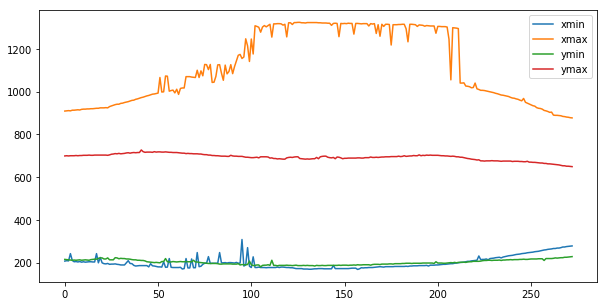

118 1374 130 777


aws s3 cp "/data/CSHL_data_processed/MD662/MD662_alignedTo_MD662&661-F115-2017.06.07-04.11.41_MD662_2_0344_prep5_cropbox.json" "s3://mousebrainatlas-data/CSHL_data_processed/MD662/MD662_alignedTo_MD662&661-F115-2017.06.07-04.11.41_MD662_2_0344_prep5_cropbox.json"
return code: 0


In [82]:
for stack in ['MD662']:
    
    bbox_all_images = []
    for fn in metadata_cache['valid_filenames'][stack]:
        mask_tb_alignedPadded = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=1, fn=fn)
        bbox = bbox_2d(mask_tb_alignedPadded)
        bbox_all_images.append(bbox)
    bbox_all_images = np.array(bbox_all_images)

#     bbox_all_images = np.array([
#         bbox_2d(DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=1, fn=fn))
#         for fn in metadata_cache['valid_filenames'][stack]
#     ])
    
    # Are the bounding boxes reasonable? If some numbers stand out, go back to check the mask.
    plt.figure(figsize=(10,5));
    plt.plot(bbox_all_images[:,0], label='xmin')
    plt.plot(bbox_all_images[:,1], label='xmax')
    plt.plot(bbox_all_images[:,2], label='ymin')
    plt.plot(bbox_all_images[:,3], label='ymax')
    plt.legend();
    plt.show();
    
    margin_um = 736
    margin = int(np.round(margin_um / convert_resolution_string_to_um(resolution=tb_resol, stack=stack)))
    alignedWithMargin_xmin, alignedWithMargin_ymin = np.maximum(bbox_all_images[:, [0,2]].min(axis=0) - margin, 0)
    alignedWithMargin_xmax, alignedWithMargin_ymax = np.minimum(bbox_all_images[:, [1,3]].max(axis=0) + margin, 
                                                                [mask_tb_alignedPadded.shape[1]-1, mask_tb_alignedPadded.shape[0]-1])
    
    print alignedWithMargin_xmin, alignedWithMargin_xmax, alignedWithMargin_ymin, alignedWithMargin_ymax 
    
    alignedWithMargin_cropbox = {'rostral_limit': alignedWithMargin_xmin, 'caudal_limit': alignedWithMargin_xmax, 
 'dorsal_limit': alignedWithMargin_ymin, 'ventral_limit': alignedWithMargin_ymax}
    
    save_data(alignedWithMargin_cropbox, 
              DataManager.get_cropbox_filename_v2(stack=stack, anchor_fn=None, prep_id='alignedWithMargin'))

In [ ]:
# metadata_cache['valid_filenames'][stack][np.where(bbox_all_images[:,2] < 60)[0][0]]

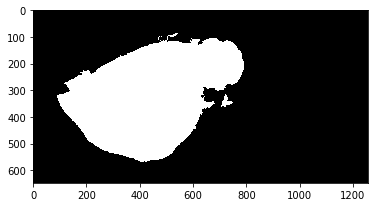

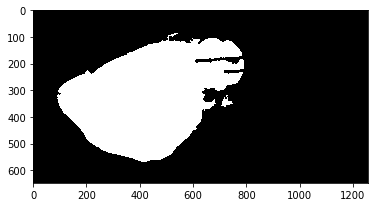

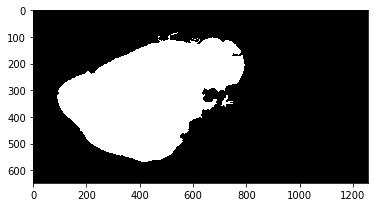

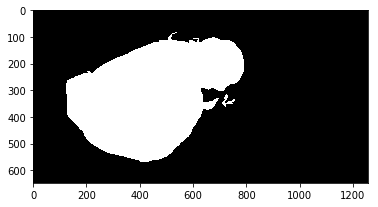

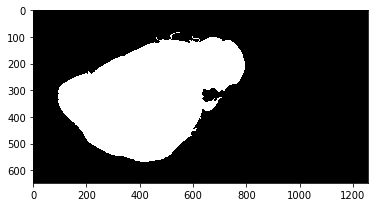

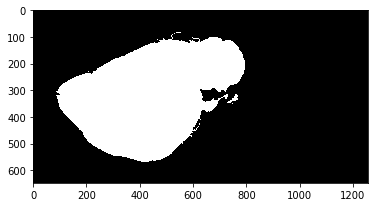

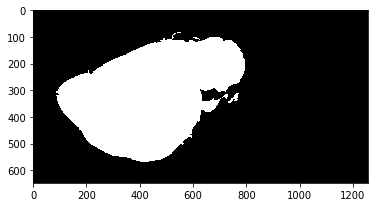

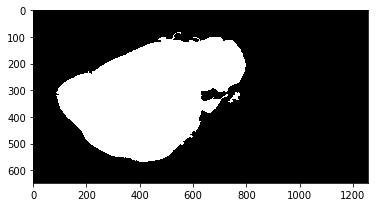

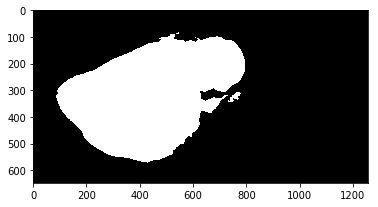

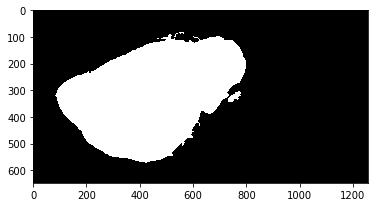

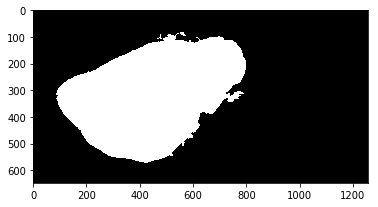

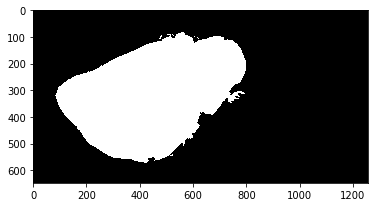

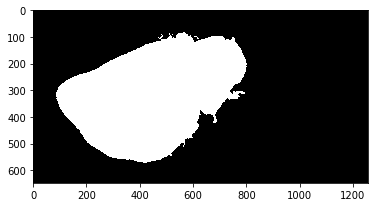

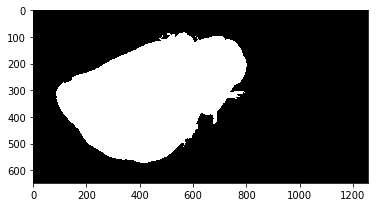

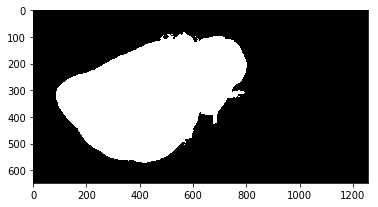

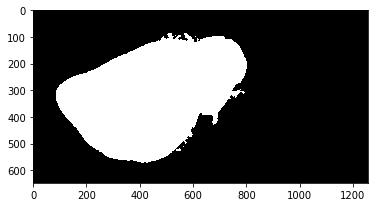

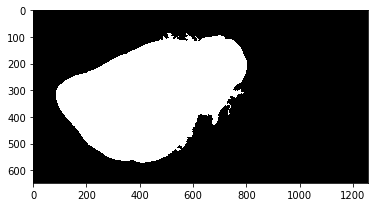

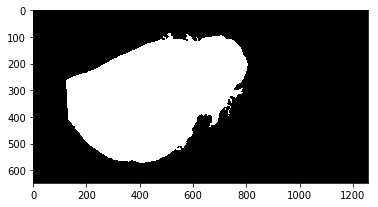

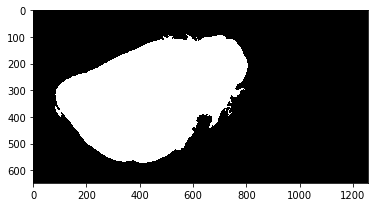

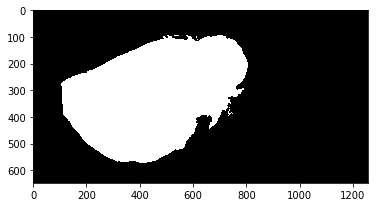

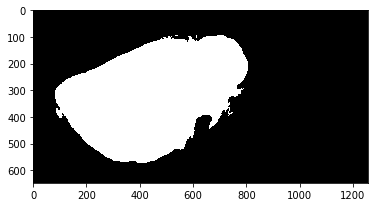

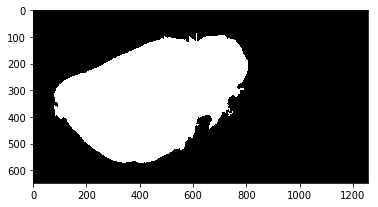

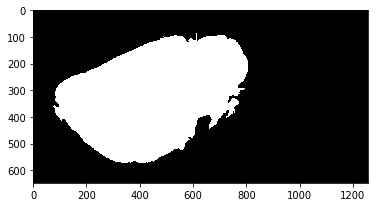

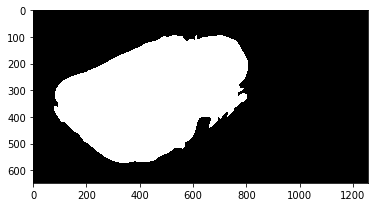

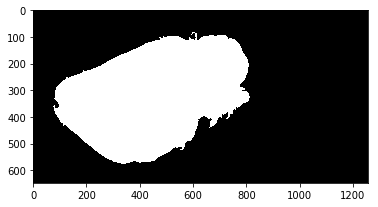

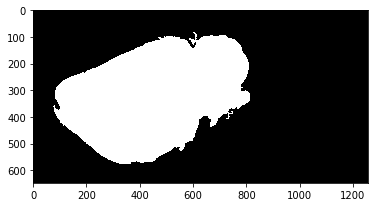

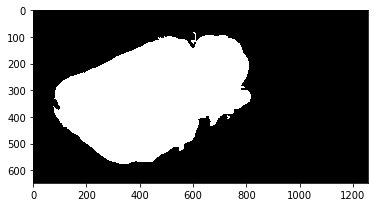

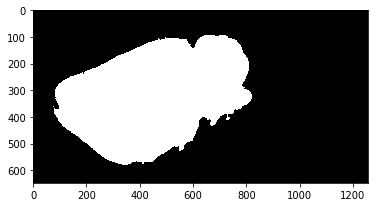

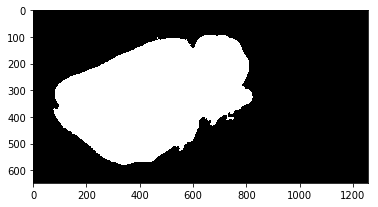

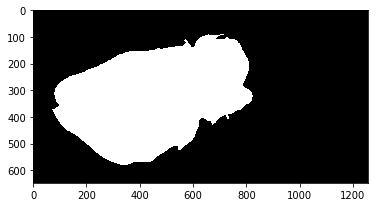

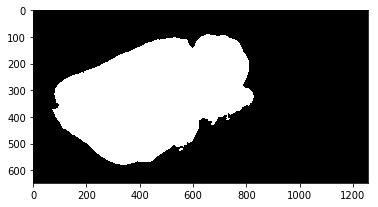

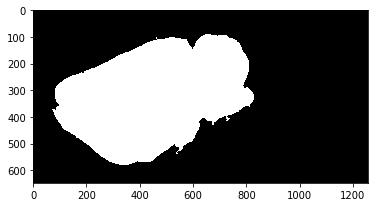

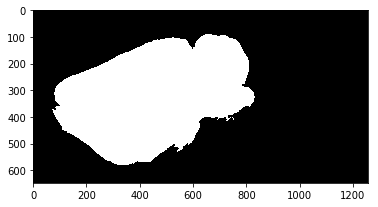

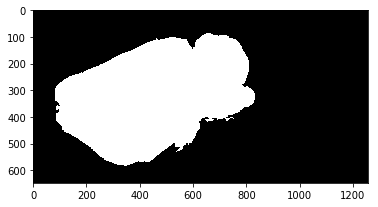

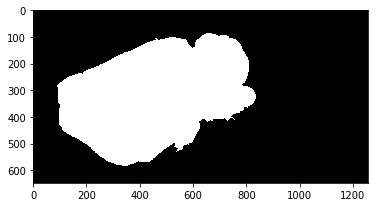

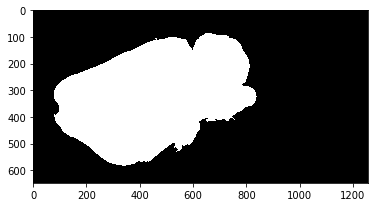

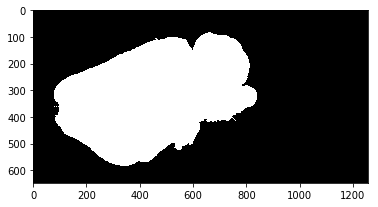

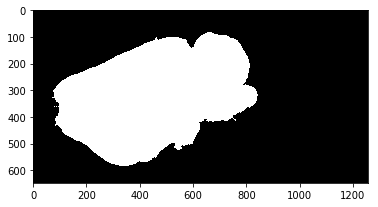

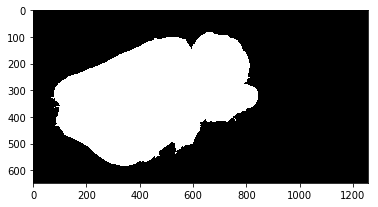

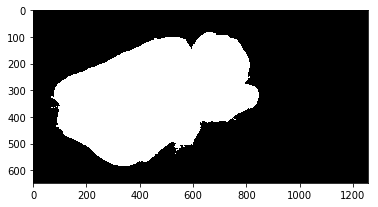

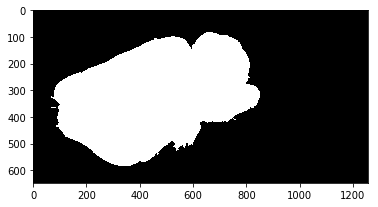

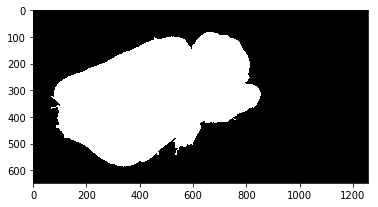

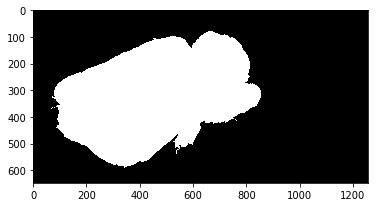

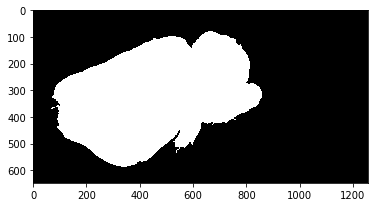

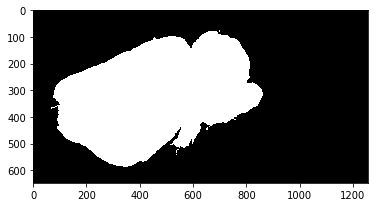

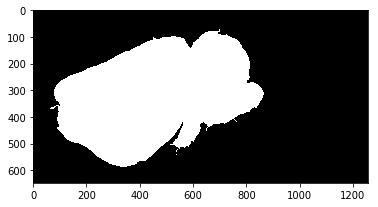

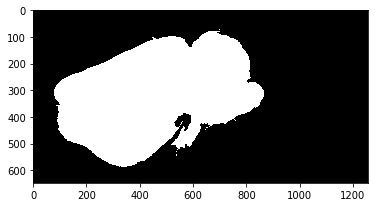

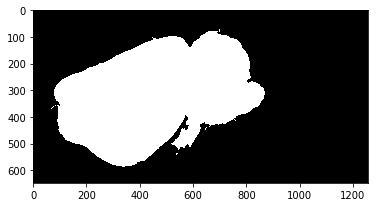

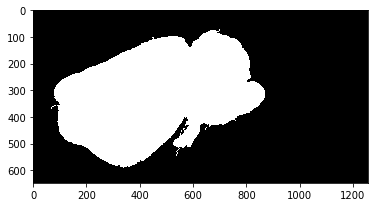

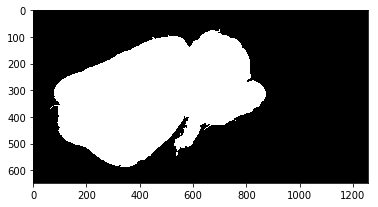

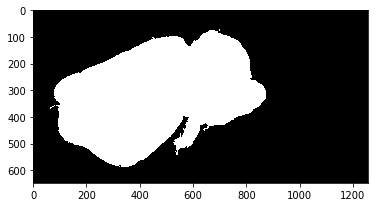

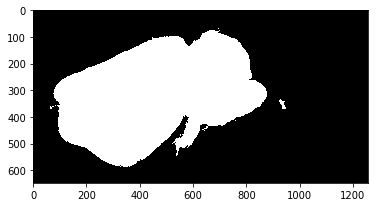

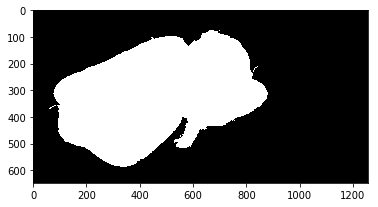

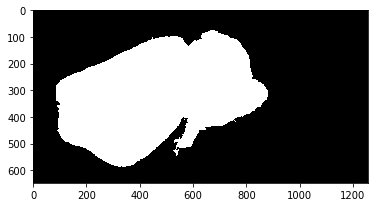

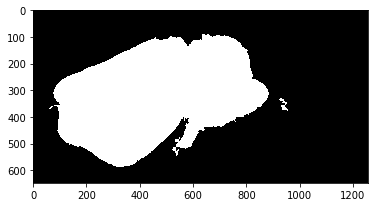

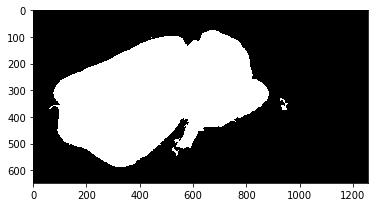

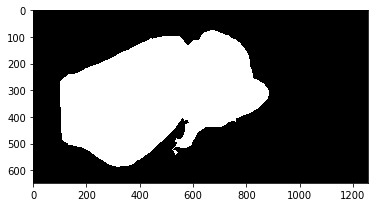

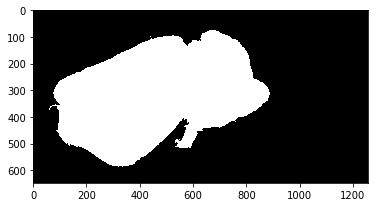

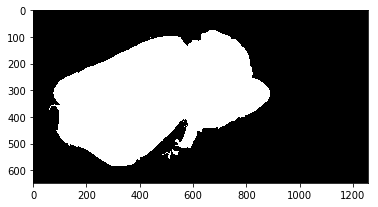

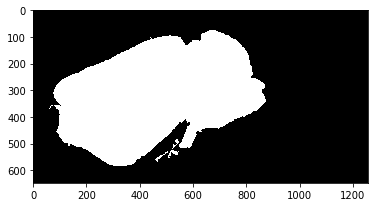

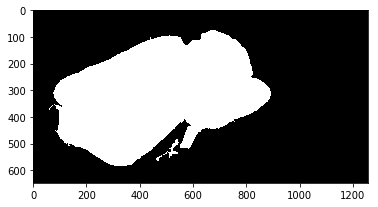

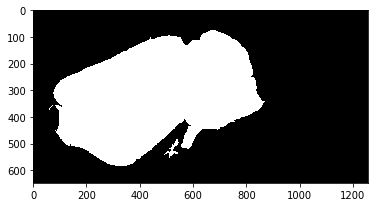

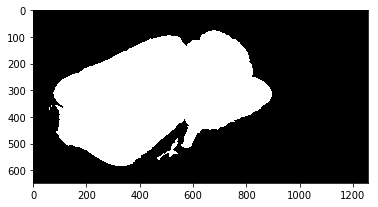

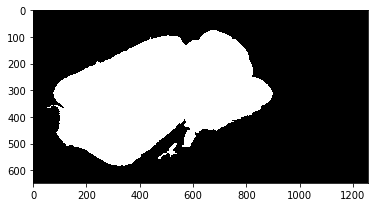

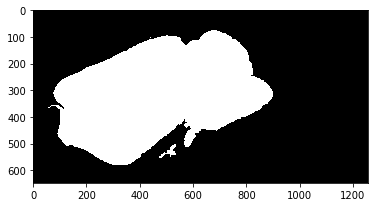

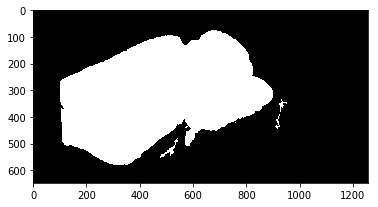

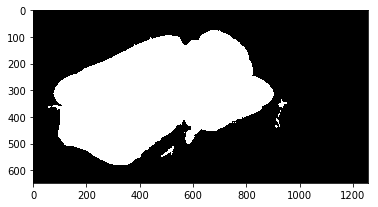

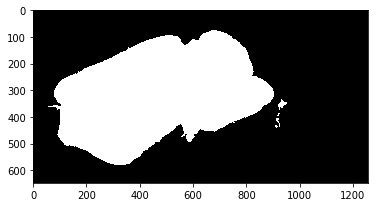

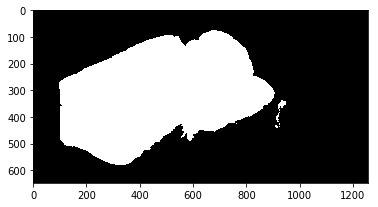

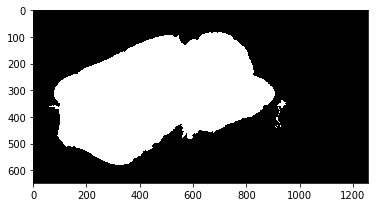

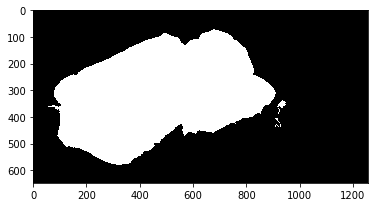

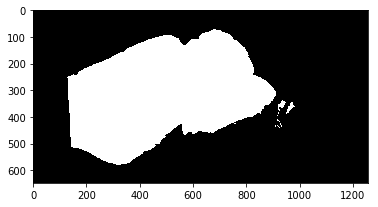

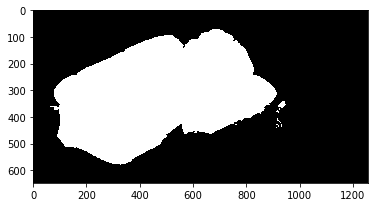

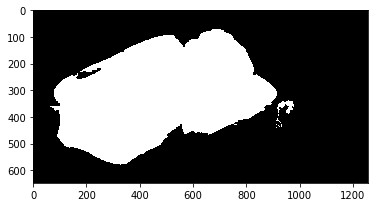

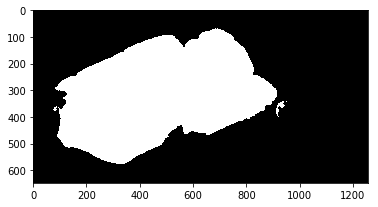

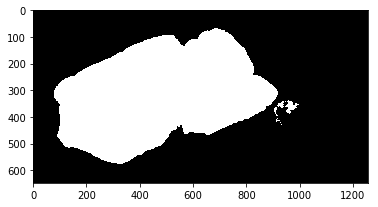

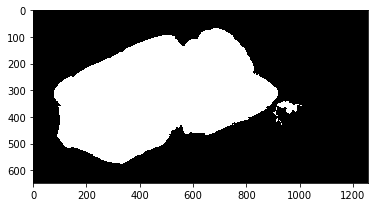

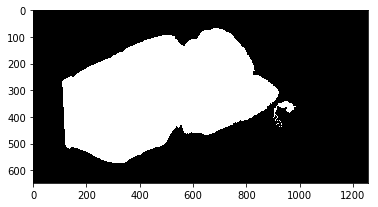

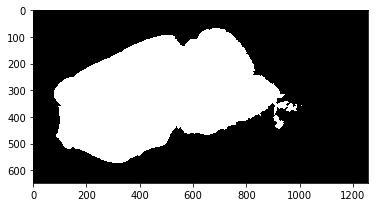

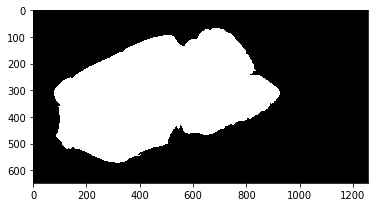

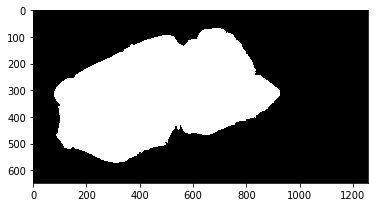

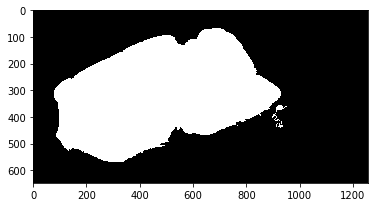

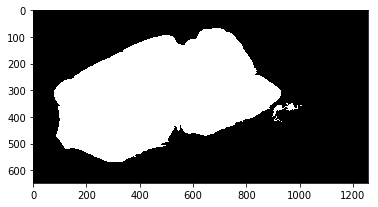

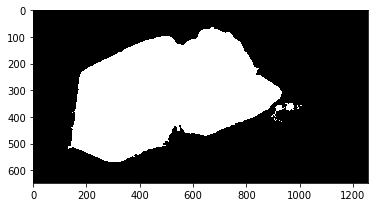

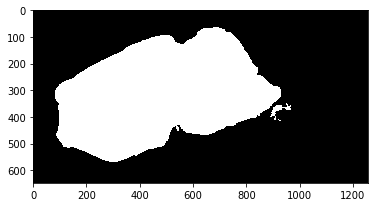

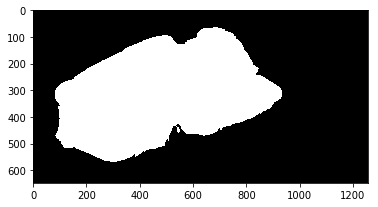

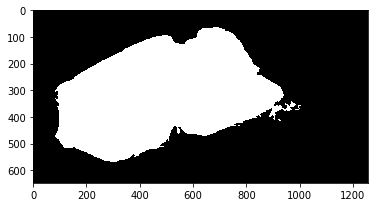

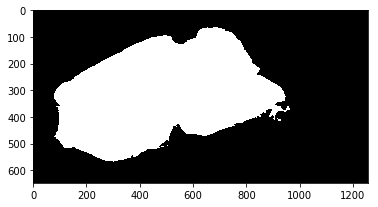

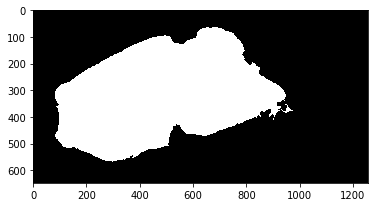

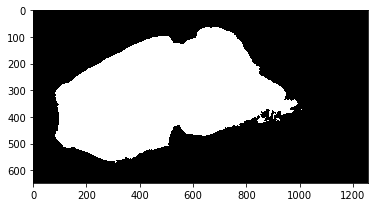

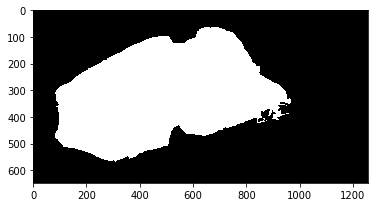

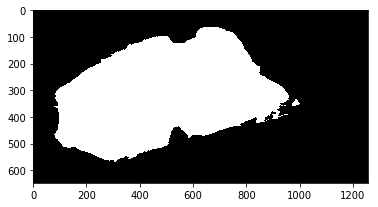

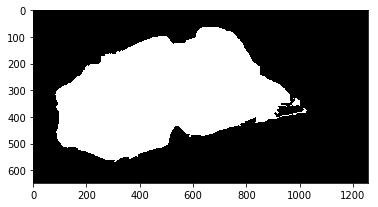

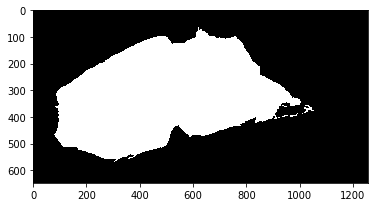

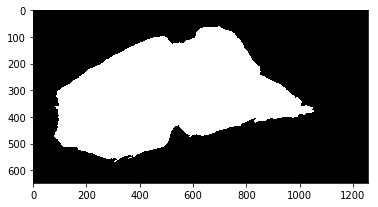

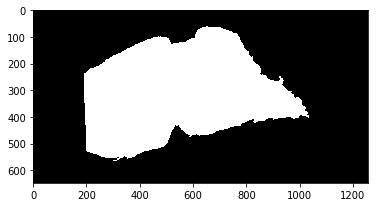

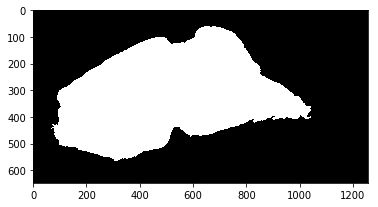

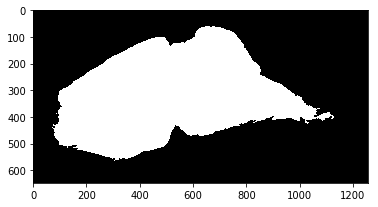

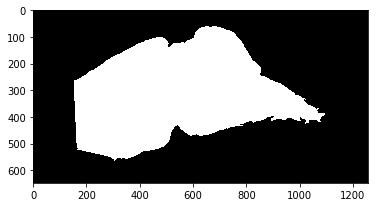

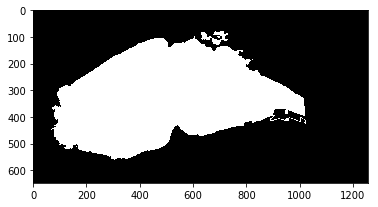

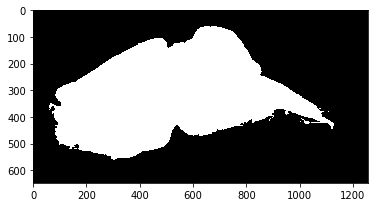

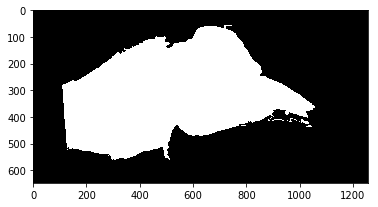

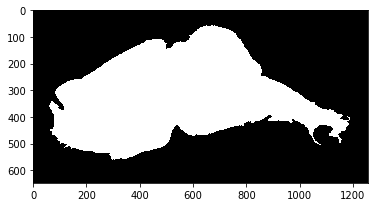

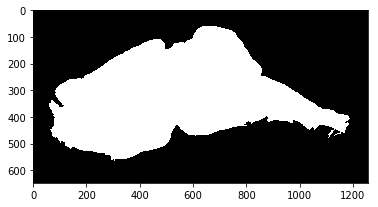

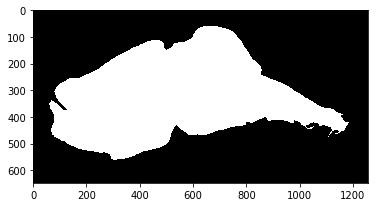

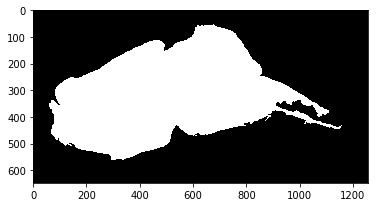

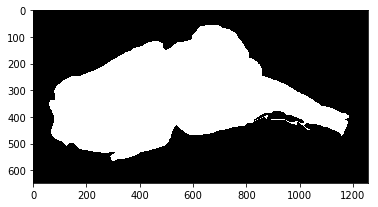

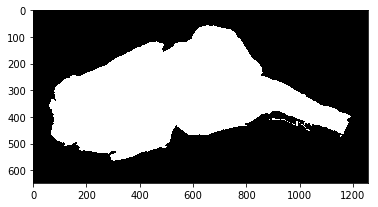

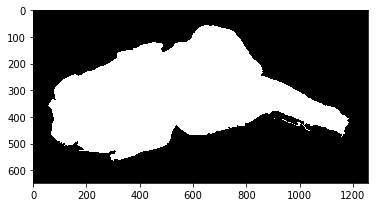

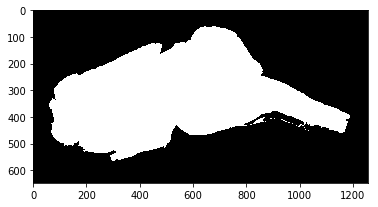

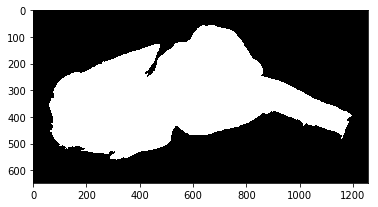

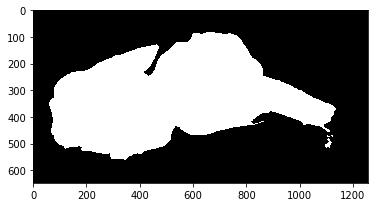

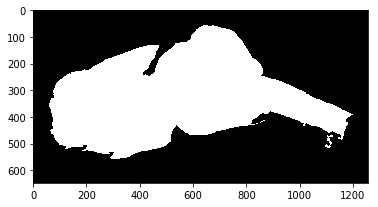

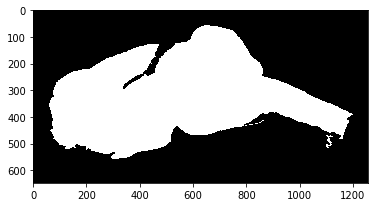

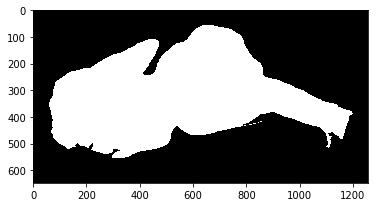

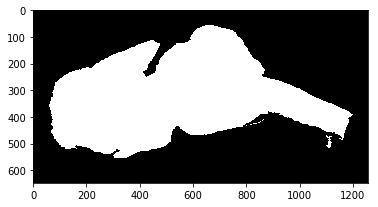

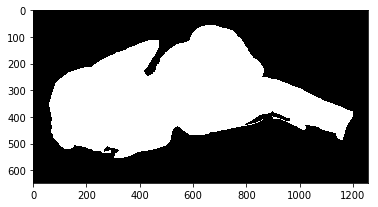

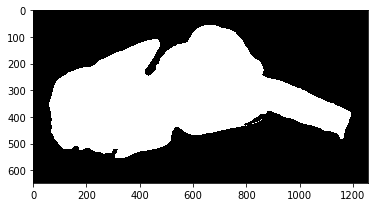

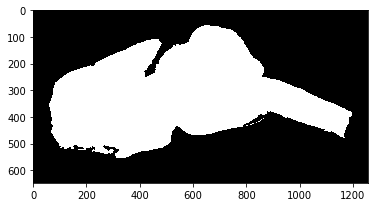

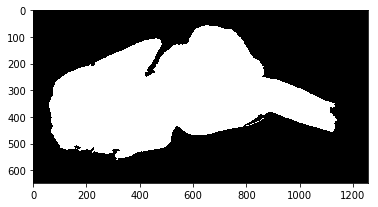

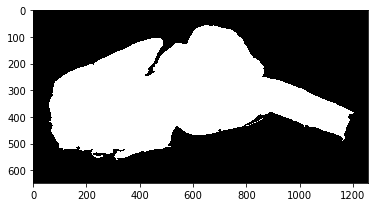

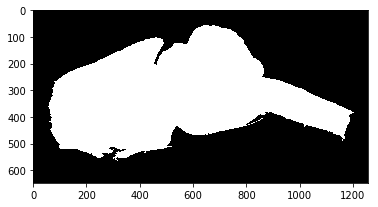

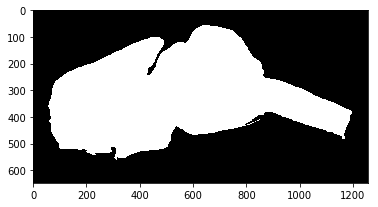

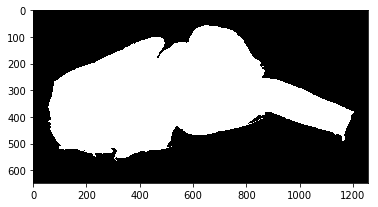

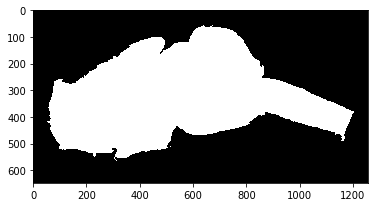

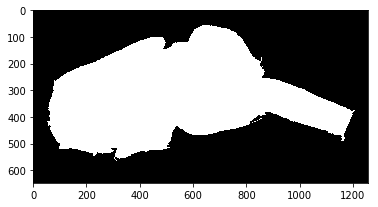

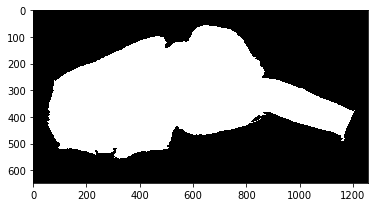

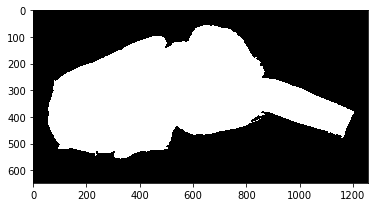

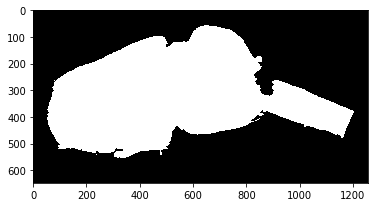

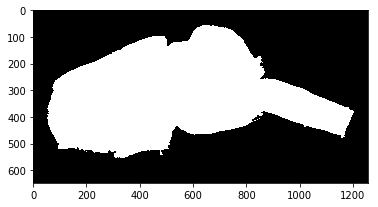

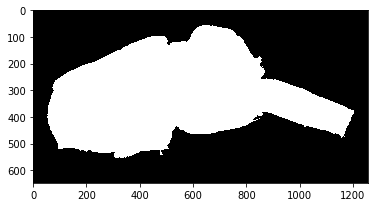

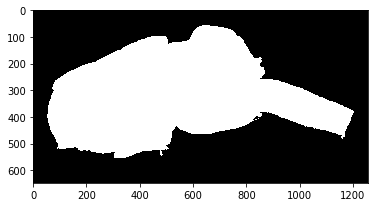

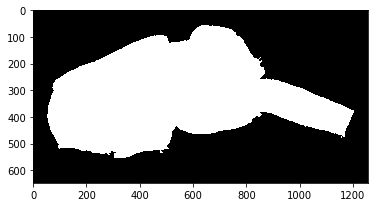

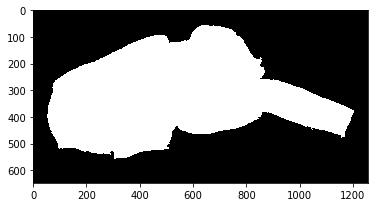

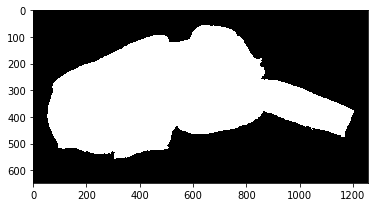

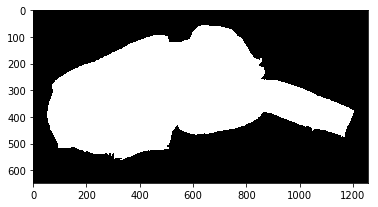

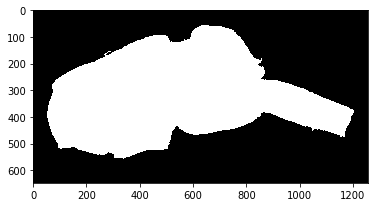

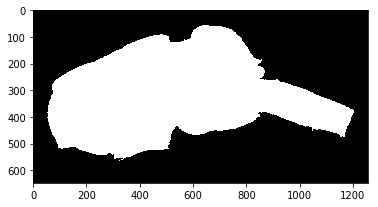

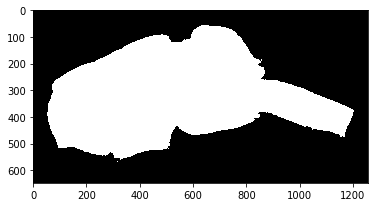

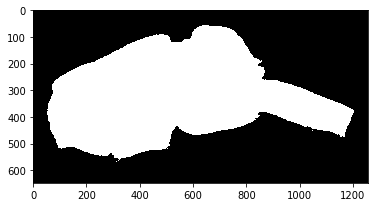

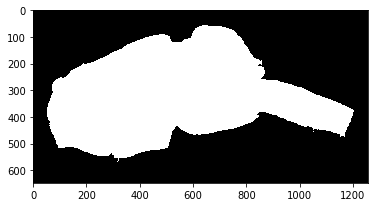

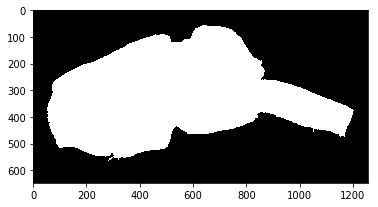

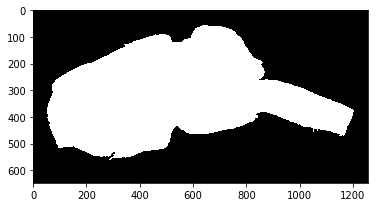

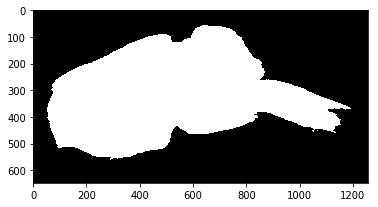

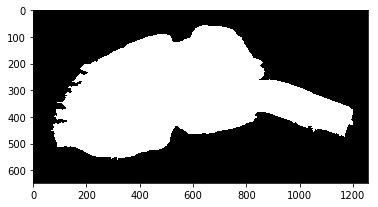

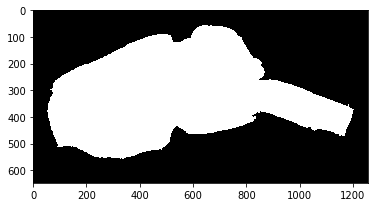

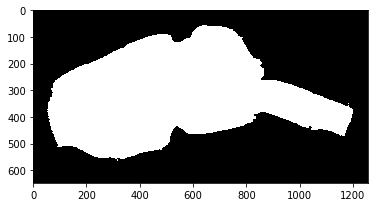

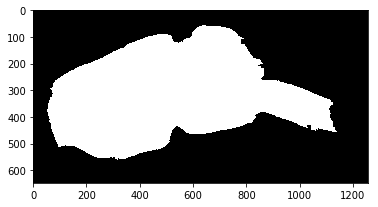

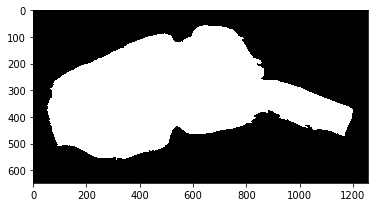

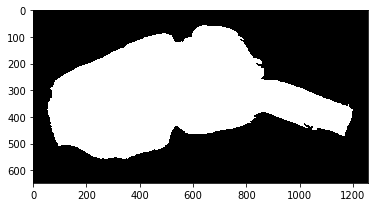

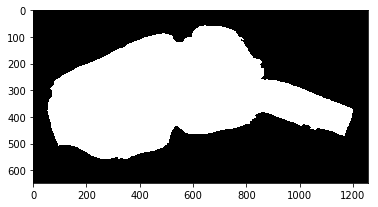

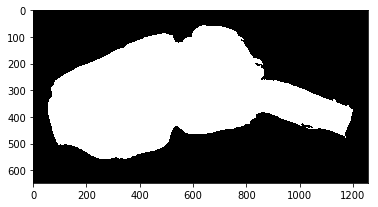

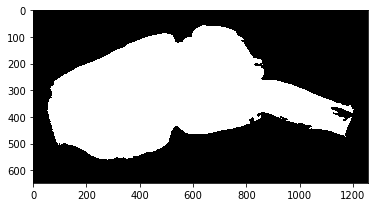

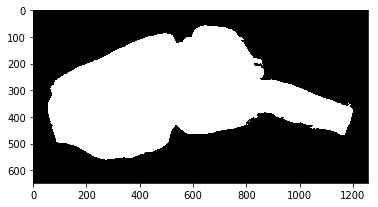

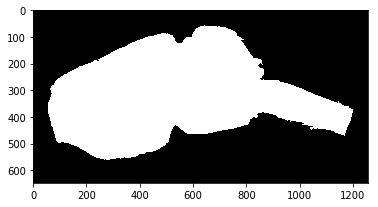

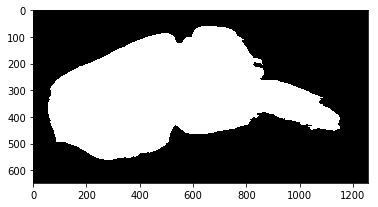

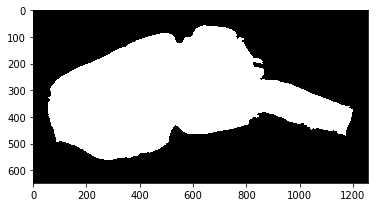

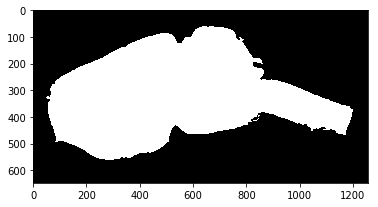

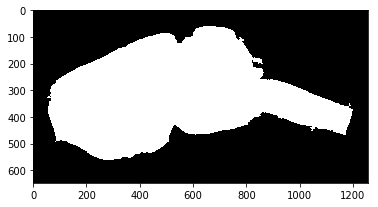

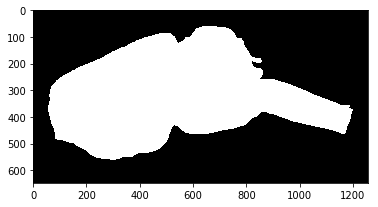

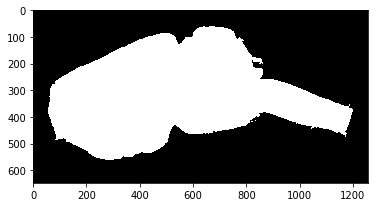

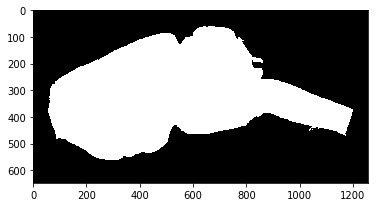

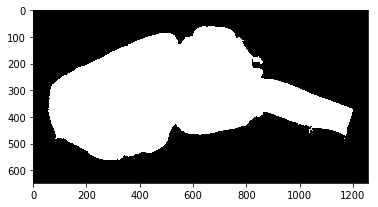

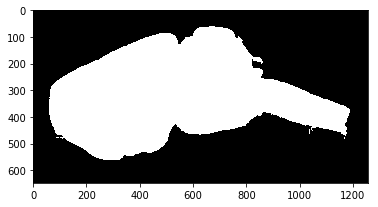

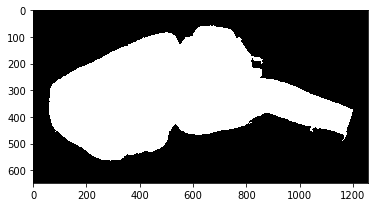

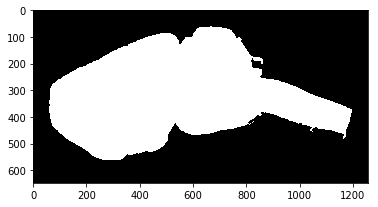

KeyboardInterrupt: 

In [83]:
for fn in metadata_cache['valid_filenames'][stack]:
    mask_tb_alignedPadded = DataManager.load_thumbnail_mask_v3(stack=stack, prep_id=1, fn=fn)
    plt.figure();
    plt.imshow(mask_tb_alignedPadded[alignedWithMargin_ymin:alignedWithMargin_ymax+1, 
                                     alignedWithMargin_xmin:alignedWithMargin_xmax+1], cmap=plt.cm.gray)
    plt.show();

# Generate prep5 thumbnails from prep1 thumbnails
prep1_thumbnail_NtbNormalized -> prep5_thumbnail_NtbNormalized

In [ ]:
for stack in ['MD662']:

    alignedWithMargin_xmin, alignedWithMargin_xmax,\
    alignedWithMargin_ymin, alignedWithMargin_ymax = DataManager.load_cropbox_v2(stack=stack, anchor_fn=None, 
                                                            prep_id='alignedWithMargin',
                                                           return_dict=False, only_2d=True)
            
#     for section in metadata_cache['valid_sections_all'][stack]: # for CHATM2 and CHATM3
    for section in metadata_cache['valid_sections'][stack]: # for MD589 etc.
        
        for version in ['NtbNormalized']:
#         for version in [None, 'mask']:

            in_fp = \
            DataManager.get_image_filepath_v2(stack=stack, prep_id=1, section=section, version=version, resol='thumbnail')

            out_fp = \
            DataManager.get_image_filepath_v2(stack=stack, prep_id=5, section=section, version=version, resol='thumbnail')

            create_parent_dir_if_not_exists(out_fp)

            t = time.time()

            im_prep1 = imread(in_fp)
            im_prep5 = im_prep1[alignedWithMargin_ymin:alignedWithMargin_ymax+1, 
                                alignedWithMargin_xmin:alignedWithMargin_xmax+1]        
            save_data(im_prep5, out_fp)
            
            sys.stderr.write('Generate prep5: %.2f seconds.\n' % (time.time() - t))

# Generate prep5 from original (transform + crop)
- raw_NtbNormalizedAdaptiveInvertedGamma -> prep5_raw_NtbNormalizedAdaptiveInvertedGamma
- thumbnail_NtbNormalized -> prep5_thumbnail_NtbNormalized

In [86]:
version = 'NtbNormalizedAdaptiveInvertedGamma'
resol = 'raw'

# version = 'NtbNormalized'
# resol = 'thumbnail'

# new_prep_id = 5
new_prep_id = 'alignedWithMargin'

if version == 'NtbNormalized': 
    pad_bg_color = 'black'
elif version == 'NtbNormalizedAdaptiveInvertedGamma':
    pad_bg_color = 'white'

In [100]:
ff = set(metadata_cache['valid_filenames'][stack]) - \
set([fp[:-49] for fp in os.listdir('/data/CSHL_data_processed/MD662/MD662_prep5_raw_NtbNormalizedAdaptiveInvertedGamma/')])

In [ ]:
for stack in ['MD662']:

    anchor_fn = DataManager.load_anchor_filename(stack=stack)
    transforms_to_anchor = DataManager.load_transforms(stack=stack, downsample_factor=32, 
                                                       use_inverse=False, anchor_fn=anchor_fn)

    alignedWithMargin_xmin, alignedWithMargin_xmax,\
    alignedWithMargin_ymin, alignedWithMargin_ymax = DataManager.load_cropbox_v2(stack=stack, anchor_fn=None, 
                                                            prep_id=new_prep_id,
                                                           return_dict=False, only_2d=True)

    x_tb = alignedWithMargin_xmin
    y_tb = alignedWithMargin_ymin
    w_tb = alignedWithMargin_xmax - alignedWithMargin_xmin + 1
    h_tb = alignedWithMargin_ymax - alignedWithMargin_ymin + 1
    
    input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=None, version=version, resol=resol)
    out_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=new_prep_id, resol=resol, version=version)
    print 'out_dir:', out_dir
    script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

    # ! rm -rf {out_dir}

    # for version in ['CHAT']:
#         for version in ['NtbNormalizedAdaptiveInvertedGamma']:
#         for version in ['NtbNormalizedAdaptiveInvertedGamma']:

    t = time.time()

    if pad_bg_color == 'auto': # useful for alternatively stained stacks where bg varies depending on stain on each section
        run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s %(resol)s %(x_tb)d %(y_tb)d %(w_tb)d %(h_tb)d %%(pad_bg_color)s' % \
                        {'script': script,
                        'stack': stack,
                         'x_tb': x_tb,
                        'y_tb': y_tb,
                        'w_tb': w_tb,
                        'h_tb': h_tb,
                         'resol': resol
                        },
                        kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[img_name].flatten())),
                                    'input_fp':\
                                      DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                                                        resol=resol, version=version, 
                                                                        fn=img_name),
                                    'output_fp':\
                                      DataManager.get_image_filepath_v2(stack=stack, fn=img_name, 
                                                                        prep_id=new_prep_id, version=version, 
                                                                        resol=resol),
                                    'pad_bg_color': 'black' if img_name.split('-')[1][0] == 'F' else 'white',
                                     }
                                    for img_name in metadata_cache['valid_filenames'][stack]
                                    ],
                        argument_type='single',
                       jobs_per_node=1,
                       local_only=True)
    else:
        run_distributed('%(script)s %(stack)s \"%%(input_fp)s\" \"%%(output_fp)s\" %%(transform)s %(resol)s %(x_tb)d %(y_tb)d %(w_tb)d %(h_tb)d %(pad_bg_color)s' % \
                        {'script': script,
                        'stack': stack,
                         'x_tb': x_tb,
                        'y_tb': y_tb,
                        'w_tb': w_tb,
                        'h_tb': h_tb,
                         'resol': resol,
                        'pad_bg_color': pad_bg_color
                        },
                        kwargs_list=[{'transform': ','.join(map(str, transforms_to_anchor[img_name].flatten())),
                                    'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=None, 
                                                                                  resol=resol, version=version, 
                                                                                  fn=img_name),
                                    'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=img_name, 
                                                                                   prep_id=new_prep_id, version=version, 
                                                                                   resol=resol),
                                     }
#                                     for img_name in metadata_cache['valid_filenames'][stack]
                                     for img_name in ff
                                    ],
                        argument_type='single',
                       jobs_per_node=8 if resol == 'thumbnail' else 1,
                       local_only=True)

    # wait_qsub_complete()

    print 'done in', time.time() - t, 'seconds'

out_dir: /data/CSHL_data_processed/MD662/MD662_prep5_raw_NtbNormalizedAdaptiveInvertedGamma


rm -f ~/stderr_*; rm -f ~/stdout_*
return code: 0
Run locally.


# Generate prep5 thumbnails from prep5 raw
prep5_raw_NtbNormalizedAdaptiveInvertedGamma -> prep5_thumbnail_NtbNormalizedAdaptiveInvertedGamma

In [41]:
thumbnail_downscale_factor = 32

In [42]:
for stack in ['MD661']:
#     stack = 'CHATM2'

    for img_name in metadata_cache['valid_filenames'][stack]:
#     for img_name in ['CHATM2_slide66_2018_02_14-S1']:

        t = time.time()

        in_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=5, resol='raw', version='NtbNormalizedAdaptiveInvertedGamma', fn=img_name)
        out_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=5, resol='thumbnail', version='NtbNormalizedAdaptiveInvertedGamma', fn=img_name)
        create_parent_dir_if_not_exists(out_fp)

        img = imread(in_fp)
        imsave(out_fp, img[::thumbnail_downscale_factor, ::thumbnail_downscale_factor])

#         execute_command('convert %(in_fp)s -scale 3.125%% %(out_fp)s' % {'in_fp':in_fp, 'out_fp':out_fp})

        sys.stderr.write("Rescale: %.2f seconds.\n" % (time.time() - t)) # ~20s / image

Rescale: 5.33 seconds.
Rescale: 5.33 seconds.
Rescale: 5.25 seconds.
Rescale: 5.42 seconds.
Rescale: 5.35 seconds.
Rescale: 5.36 seconds.
Rescale: 5.35 seconds.
Rescale: 5.46 seconds.
Rescale: 5.43 seconds.
Rescale: 5.66 seconds.
Rescale: 5.63 seconds.
Rescale: 5.62 seconds.
Rescale: 5.80 seconds.
Rescale: 5.96 seconds.
Rescale: 5.72 seconds.
Rescale: 5.86 seconds.
Rescale: 5.84 seconds.
Rescale: 5.82 seconds.
Rescale: 5.61 seconds.
Rescale: 5.69 seconds.
Rescale: 5.69 seconds.
Rescale: 5.71 seconds.
Rescale: 5.88 seconds.
Rescale: 5.74 seconds.
Rescale: 5.85 seconds.
Rescale: 5.85 seconds.
Rescale: 5.67 seconds.
Rescale: 5.79 seconds.
Rescale: 5.96 seconds.
Rescale: 5.89 seconds.
Rescale: 5.90 seconds.
Rescale: 6.11 seconds.
Rescale: 5.87 seconds.
Rescale: 6.15 seconds.
Rescale: 6.09 seconds.
Rescale: 6.12 seconds.
Rescale: 6.00 seconds.
Rescale: 6.09 seconds.
Rescale: 6.08 seconds.
Rescale: 6.14 seconds.
Rescale: 6.15 seconds.
Rescale: 6.16 seconds.
Rescale: 6.10 seconds.
Rescale: 6.

# Crop prep2 from prep5
- prep5_raw_NtbNormalizedAdaptiveInvertedGamma -> prep2_raw_NtbNormalizedAdaptiveInvertedGamma

In [7]:
from multiprocess import Pool

In [8]:
def f(stack, img_name, version, resol, x,y,w,h):

    input_fp = DataManager.get_image_filepath_v2(stack=stack, prep_id=5, resol=resol, version=version, fn=img_name)
    output_fp = DataManager.get_image_filepath_v2(stack=stack, fn=img_name, prep_id=2, version=version, resol=resol)

    img = imread(input_fp)
    save_data(img[y:y+h, x:x+w], output_fp)

In [10]:
# for stack in ['CHATM2', 'CHATM3']:
for stack in ['MD662']:
    
    alignedBrainstemCrop_xmin_wrt_alignedWithMargin, \
    alignedBrainstemCrop_xmax_wrt_alignedWithMargin,\
    alignedBrainstemCrop_ymin_wrt_alignedWithMargin,\
    alignedBrainstemCrop_ymax_wrt_alignedWithMargin = \
    DataManager.load_cropbox_v2_relative(stack=stack, 
                                       prep_id='alignedBrainstemCrop', 
                                       wrt_prep_id='alignedWithMargin', 
                                       out_resolution='down32')
    
    x_tb = alignedBrainstemCrop_xmin_wrt_alignedWithMargin
    y_tb = alignedBrainstemCrop_ymin_wrt_alignedWithMargin
    w_tb = alignedBrainstemCrop_xmax_wrt_alignedWithMargin - alignedBrainstemCrop_xmin_wrt_alignedWithMargin + 1
    h_tb = alignedBrainstemCrop_ymax_wrt_alignedWithMargin - alignedBrainstemCrop_ymin_wrt_alignedWithMargin + 1
    
#     alignedBrainstemCrop_xmin, alignedBrainstemCrop_xmax, \
#     alignedBrainstemCrop_ymin, alignedBrainstemCrop_ymax = DataManager.load_cropbox_v2(stack=stack, prep_id='alignedBrainstemCrop', only_2d=True)

#     alignedWithMargin_xmin, alignedWithMargin_xmax,\
#     alignedWithMargin_ymin, alignedWithMargin_ymax = DataManager.load_cropbox_v2(stack=stack, anchor_fn=None, 
#                                                             prep_id='alignedWithMargin',
#                                                            return_dict=False, only_2d=True)

#     alignedBrainstemCrop_xmin_wrt_alignedWithMargin = alignedBrainstemCrop_xmin - alignedWithMargin_xmin
#     alignedBrainstemCrop_xmax_wrt_alignedWithMargin = alignedBrainstemCrop_xmax - alignedWithMargin_xmin
#     alignedBrainstemCrop_ymin_wrt_alignedWithMargin = alignedBrainstemCrop_ymin - alignedWithMargin_ymin
#     alignedBrainstemCrop_ymax_wrt_alignedWithMargin = alignedBrainstemCrop_ymax - alignedWithMargin_ymin

#     print alignedBrainstemCrop_xmin_wrt_alignedWithMargin,\
#     alignedBrainstemCrop_xmax_wrt_alignedWithMargin,\
#     alignedBrainstemCrop_ymin_wrt_alignedWithMargin,\
#     alignedBrainstemCrop_ymax_wrt_alignedWithMargin

#     x_tb = alignedBrainstemCrop_xmin_wrt_alignedWithMargin
#     y_tb = alignedBrainstemCrop_ymin_wrt_alignedWithMargin
#     w_tb = alignedBrainstemCrop_xmax_wrt_alignedWithMargin - alignedBrainstemCrop_xmin_wrt_alignedWithMargin + 1
#     h_tb = alignedBrainstemCrop_ymax_wrt_alignedWithMargin - alignedBrainstemCrop_ymin_wrt_alignedWithMargin + 1

#     for version in ['NtbNormalizedAdaptiveInvertedGamma', 'CHAT']:
#     for version in ['CHAT']:
    for version in ['NtbNormalizedAdaptiveInvertedGamma']:
#     for version in ['mask']:
#         for resol in ['thumbnail']:
        for resol in ['raw']:
            
            if resol == 'raw':
                x = x_tb * 32
                y = y_tb * 32
                w = w_tb * 32
                h = h_tb * 32
            elif resol == 'thumbnail':
                x = x_tb
                y = y_tb
                w = w_tb
                h = h_tb
            else:
                raise

#             input_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=5, version=version, resol='raw')
            out_dir = DataManager.get_image_dir_v2(stack=stack, prep_id=2, resol=resol, version=version)
            print 'out_dir:', out_dir
#             script = os.path.join(REPO_DIR, 'preprocess', 'warp_crop_IM_v3.py')

    #         ! rm -rf {out_dir}
            create_if_not_exists(out_dir)

            t = time.time()

            pool = Pool(4)
            _ = pool.map(lambda img_name: f(stack=stack, img_name=img_name, version=version, resol=resol, 
                                            x=x, y=y, w=w, h=h), 
                         metadata_cache['valid_filenames'][stack])
            pool.close()
            pool.join()

#             for img_name in metadata_cache['valid_filenames'][stack]:
#                 f(stack=stack, img_name=img_name, version=version, resol=resol, 
#                                             x=x, y=y, w=w, h=h)

        #     run_distributed('convert \"%%(input_fp)s\" -crop %(w)dx%(h)d+%(x)d+%(y)d  \"%%(output_fp)s\"' % \
        #                     {'w':w_raw, 'h':h_raw, 'x':x_raw, 'y':y_raw},
        #                     kwargs_list=[{'input_fp': DataManager.get_image_filepath_v2(stack=stack, prep_id=5, resol='raw', version=version, fn=img_name),
        #                                   'output_fp': DataManager.get_image_filepath_v2(stack=stack, fn=img_name, prep_id=2, version=version, resol='raw')}
        #                                  for img_name in metadata_cache['valid_filenames'][stack]],
        # #                                  for img_name in ['CHATM3_slide35_2018_02_17-S1']],
        #                     argument_type='single',
        #                    jobs_per_node=1,
        #                    local_only=True)

            # wait_qsub_complete()

            print 'done in', time.time() - t, 'seconds' # 1500s

out_dir: /data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma


aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F35-2017.06.05-17.08.18_MD661_3_0105_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-dat

return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F37-2017.06.05-18.09.08_MD661_2_0110_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F48-2017.06.05-23.36.49_MD661_3_0144_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F43-2017.06.05-21.05.21_MD661_1_0127_prep2_raw_NtbNo

return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F44-2017.06.05-21.36.28_MD661_3_0132_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F39-2017.06.05-19.07.49_MD661_2_0116_prep2_raw_NtbNo

return code: 0
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F46-2017.06.05-22.36.28_MD661_2_0137_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F52-2017.06.06-01.35.53_MD661_3_0156_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F41-2017.06.05-20.06.59_MD661_1_0121_prep2_raw_NtbNo

aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F65-2017.06.06-06.05.08_MD661_2_0194_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F59-2017.06.06-03.05.00_MD661_3_0177_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F59-2017.06.06-03.05.00_MD661_3_0177_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F54-2017.06.22-17.00.44_MD661_2_0161_prep2_raw_NtbNormalizedAdaptiv

aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F67-2017.06.06-07.07.27_MD661_2_0200_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F67-2017.06.06-07.07.27_MD661_2_0200_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F61-2017.06.06-04.06.02_MD661_2_0182_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F61-2017.06.06-04.06.02_MD661_2_0182_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
return code: 0
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F61-2017.06.06-04.06.02_MD661_3_0183_prep2_raw_NtbNo

return code: 0
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F57-2017.06.06-02.06.22_MD661_3_0171_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F57-2017.06.06-02.06.22_MD661_3_0171_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F77-2017.06.06-11.00.56_MD661_2_0230_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F77-2017.06.06-11.00.56_MD661_2_0230_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F58-2017.06.06-02.35.45_MD661_1_0172_

aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F89-2017.06.06-16.49.49_MD661_1_0265_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F89-2017.06.06-16.49.49_MD661_1_0265_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F98-2017.06.06-20.47.32_MD661_1_0292_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F98-2017.06.06-20.47.32_MD661_1_0292_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F105-2017.06.06-23.53.33_MD661_2_0314_prep2_raw_NtbNormalizedAdapti

return code: 0
return code: 0
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F84-2017.06.06-14.03.51_MD661_2_0251_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F84-2017.06.06-14.03.51_MD661_2_0251_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F100-2017.06.06-21.40.10_MD661_2_0299_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F100-2017.06.06-21.40.10_MD661_2_0299_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F92-2017.06.06-18.08.17_MD661_1_0274_prep2_raw_Ntb

return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F94-2017.06.06-19.01.05_MD661_2_0281_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F94-2017.06.06-19.01.05_MD661_2_0281_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F103-2017.06.06-22.56.22_MD661_1_0307_prep2_raw_NtbNormalizedAdaptiveInvertedGamma

return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F115-2017.06.07-04.11.41_MD661_1_0343_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F115-2017.06.07-04.11.41_MD661_1_0343_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F113-2017.06.07-03.19.59_MD661_1_0337_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F113-2017.06.07-03.19.59_MD661_1_0337_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F122-2017.06.07-15.19.59_MD661_2_0365_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3:/

aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F126-2017.06.07-17.13.02_MD661_1_0376_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F126-2017.06.07-17.13.02_MD661_1_0376_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F131-2017.06.07-19.36.32_MD661_3_0393_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F131-2017.06.07-19.36.32_MD661_3_0393_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F136-2017.06.07-22.02.11_MD661_2_0407_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3:/

aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F138-2017.06.07-23.00.07_MD661_1_0412_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F138-2017.06.07-23.00.07_MD661_1_0412_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F127-2017.06.07-17.34.51_MD661_2_0380_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
return code: 0
return code: 0
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F138-2017.06.07-23.00.07_MD661_2_0413_prep2_raw_

return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F140-2017.06.07-23.55.43_MD661_2_0419_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F140-2017.06.07-23.55.43_MD661_2_0419_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif"
return code: 0


done in 1463.65569592 seconds


# Compress prep2 to JPEG
prep2_raw_NtbNormalizedAdaptiveInvertedGamma -> prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg

In [17]:
for stack in ['MD661']:

    for section in metadata_cache['valid_sections'][stack]:
        
#         for version in ['NtbNormalizedAdaptiveInvertedGamma', 'CHAT']:
        for version in ['NtbNormalizedAdaptiveInvertedGamma']:

            in_fp = \
            DataManager.get_image_filepath_v2(stack=stack, prep_id=2, section=section, version=version, resol='raw')

            out_fp = \
            DataManager.get_image_filepath_v2(stack=stack, prep_id=2, section=section, version=version+'Jpeg', resol='raw')

            create_parent_dir_if_not_exists(out_fp)

            t = time.time()
            execute_command("convert \"%(in_fp)s\" \"%(out_fp)s\"" % {'in_fp': in_fp, 'out_fp': out_fp})
            sys.stderr.write('Convert to JPEG: %.2f seconds.\n' % (time.time() - t)) # 14s

            upload_to_s3(out_fp)

convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.43 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F30-2017.06.05-14.49.48_MD661_1_0088_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F30-2017.06.05-14.49.48_MD661_2_0089_prep2_raw_NtbN

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.58 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F33-2017.06.05-16.09.53_MD661_2_0098_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F33-2017.06.05-16.09.53_MD661_3_0099

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.64 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F36-2017.06.05-17.38.33_MD661_3_0108_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F37-2017.06.05-18.09.08_MD661_1_0109

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 8.63 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F40-2017.06.05-19.36.43_MD661_1_0118_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F40-2017.06.05-19.36.43_MD661_2_0119

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.54 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F43-2017.06.05-21.05.21_MD661_2_0128_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F43-2017.06.05-21.05.21_MD661_3_0129

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.19 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F46-2017.06.05-22.36.28_MD661_3_0138_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F47-2017.06.05-23.06.43_MD661_1_0139

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.75 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F50-2017.06.06-00.35.44_MD661_1_0148_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F50-2017.06.06-00.35.44_MD661_2_0149

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.73 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F53-2017.06.08-17.11.31_MD661_2_0158_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F53-2017.06.08-17.11.31_MD661_3_0159

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.88 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F56-2017.06.08-18.42.36_MD661_3_0168_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F57-2017.06.06-02.06.22_MD661_1_0169

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 8.00 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F60-2017.06.06-03.35.37_MD661_1_0178_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F60-2017.06.06-03.35.37_MD661_2_0179

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.98 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F63-2017.06.06-05.05.24_MD661_2_0188_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F63-2017.06.06-05.05.24_MD661_3_0189

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.60 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F66-2017.06.06-06.35.52_MD661_3_0198_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F67-2017.06.06-07.07.27_MD661_1_0199

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.80 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F70-2017.06.06-08.36.23_MD661_2_0209_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F71-2017.06.06-09.00.35_MD661_1_0211

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.95 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F76-2017.06.06-16.23.52_MD661_2_0227_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F77-2017.06.06-11.00.56_MD661_1_0229

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.29 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F81-2017.06.06-12.44.40_MD661_2_0242_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F82-2017.06.06-13.10.59_MD661_1_0244

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.97 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F86-2017.06.06-14.56.48_MD661_2_0257_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F87-2017.06.06-15.22.59_MD661_1_0259

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.57 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F91-2017.06.06-17.42.59_MD661_2_0272_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F92-2017.06.06-18.08.17_MD661_1_0274

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.11 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F96-2017.06.06-19.55.10_MD661_2_0287_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F97-2017.06.06-20.20.43_MD661_1_0289

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 8.23 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F101-2017.06.06-22.05.45_MD661_2_0302_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F102-2017.06.06-22.30.50_MD661_1

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 8.12 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F106-2017.06.07-00.20.03_MD661_2_0317_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F107-2017.06.07-00.44.42_MD661_1

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.98 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F111-2017.06.07-02.28.23_MD661_2_0332_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F112-2017.06.07-02.53.08_MD661_1

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 8.86 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F116-2017.06.07-04.39.41_MD661_2_0347_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F118-2017.06.07-11.26.45_MD661_1

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.90 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F121-2017.06.07-14.55.33_MD661_2_0362_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F122-2017.06.07-15.19.59_MD661_1

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.51 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F125-2017.06.07-16.50.51_MD661_2_0374_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F127-2017.06.07-17.34.51_MD661_1

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.65 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F130-2017.06.07-19.06.02_MD661_1_0388_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F130-2017.06.07-19.06.02_MD661_2

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.71 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F133-2017.06.07-20.35.00_MD661_2_0398_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F133-2017.06.07-20.35.00_MD661_3

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 7.57 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F136-2017.06.07-22.02.11_MD661_3_0408_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F137-2017.06.07-22.31.13_MD661_1

return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_raw_NtbNormalizedAdaptiveInvertedGamma.tif" "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
Convert to JPEG: 6.20 seconds.
aws s3 cp "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg" "s3://mousebrainatlas-data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg/MD662&661-F140-2017.06.07-23.55.43_MD661_1_0418_prep2_raw_NtbNormalizedAdaptiveInvertedGammaJpeg.jpg"
return code: 0
convert "/data/CSHL_data_processed/MD661/MD661_prep2_raw_NtbNormalizedAdaptiveInvertedGamma/MD662&661-F140-2017.06.07-23.55.43_MD661_2